## Goal

The goal of this project is to predict an NFL receiver's separation at the time of pass arrival. I will be using the NFL's player-tracking data set from the last 3 seasons (2017-2019) to create these predictions

## Motivation

All receivers are NOT built equal. Receivers like Tyler Lockett (Seahawks) are short, quick, and line up in the 'Slot' often, some are like Cooper Kupp, who are bigger, line up 'Tight' to the line of scrimmage, and excel at running routes. Others are strong, have large frames and excel in tight windows (Allen Robinson, Bears or Mike Evans, Bucs) and often line up out 'Wide'. Since these players have different body types, abilities, and team roles, I don't think it's fair to compare their receiver separations. To this end, I want to look into how much separation a receiver gains RELATIVE to their situations/role. 

For example, a receiver that lines up out 'Wide', is pressed at the line of scrimage, and is targeted 20 yards downfield should have little to no separation when the pass arrives. In contrast, a reciver that lines up in the slot and is targeted 3 yards behind the line of scrimmage should expect to have more separation.

When aggregated over a course of a game, season, or career, this 'expected separation' value should bring context into the players TRUE ability to separate given their in-play circumstances.



In [2]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
import fancyimpute 
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

# Machine Learning Modeling and Cross-Validation/Accuracy 
import sklearn

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
LoadData = "../data/ExpSepPos.csv"

df = pd.read_csv(LoadData, index_col = False)

random_state = 1

In [4]:
print(df.shape)
print(max(df['GameId']))
print(min(df['GameId']))
df.head()

(53710, 31)
2020020200
2017090700


,GameId,PlayId,Season,Team,Receiver,Nearest_Defender,Nearest_Def_Position,Opp,Wk,Qtr,...,Air_Dist,Air_Time,TTT,Separation,QB_Separation,QBP,QB_Scramble_Yds,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist
0,2017102910,2814,2017,PIT,JuJu Smith-Schuster,Quandre Diggs,SS,DET,8,3,...,33.119846,1.539,2.756,1.785385,2.084347,0,4.12,26.303329,1.145455,37.540001
1,2018112509,2475,2018,PIT,JuJu Smith-Schuster,Bradley Roby,CB,DEN,12,3,...,37.510450,2.202,2.436,2.674790,1.540033,1,7.09,12.303331,3.763636,40.230003
2,2017111208,2731,2017,LA,Robert Woods,Johnathan Joseph,CB,HOU,10,3,...,52.871040,2.633,3.135,3.966674,3.386576,0,7.52,17.230000,1.247727,58.880001
3,2019120800,2777,2019,ATL,Olamide Zaccheaus,Donte Jackson,CB,CAR,14,3,...,49.233444,3.018,2.771,0.910220,2.814427,0,5.20,19.433328,1.329546,56.439999
4,2019101310,1630,2019,NYJ,Robby Anderson,Jeff Heath,SS,DAL,6,2,...,46.187710,2.636,3.003,1.676305,1.471224,1,6.58,15.103330,3.477273,57.060001


Our Dataset spans 3 years (2017-2020) and includes regular and postseason games. We have a total of 53,710 total passes with non-null receiver separations to work with. 

# Predicting Receiver Separation

## Data Cleaning

- Handle missing values
    - Discuss various ways to impute missing/null values
    - Remove Rows with missing cushion?
- Handle Outliers

## Data Exploration

- Feature Analysis
    - Numerical Features
        - Discrete Features
        - Continuous Features
    - Categorical Features
- Feature Engineering
    - Nearest Defender Position into broader groups
    
## Model Selection

- Choosing the right Model
    - Linear Regression
        - LASSO Regression
        - Ridge Regression
        - Huber Loss Regressor
    - Random Forest
    - eXtreme Gradient Boosting
    - Light Gradient Boosting 

In [5]:
# Describing all the Numerical Features
df.describe()
COLS = df.columns.to_list()

In [6]:
# Describing all the Categorical Features
#df.describe(include=['O'])

## Dropping non-relevant features 

Right off the bat, I think a lot the variables in this dataset will not be useful in predicting reciever separation. Also, there are a lot features in this set that describe the outcome of the event. These features (Pass Yards, TD, INT) cannot be used in prediction. For features that I am skeptical of, but not sure about their effect, I will leave alone, otherwise I will drop all non-essential features below.

In [7]:
IrrelevantCols = ['GameId', 'PlayId', 'Season', 'Wk', 'Cmp', 'Team', 'Receiver', 'Nearest_Defender', 'Opp', 'Wk', 'Cmp', 'Pass Yds','TD', 'INT',
 'Comp_Prob', 'Separation', 'Time', 'QB_Scramble_Yds', 'QB_Speed_at_Pass', 'TTT']

# Drop all irrelevant columns and output variable (separation)
Features = df.drop(IrrelevantCols, axis = 1)

#Create 1-dimensional array of output variable (separation)
Output = df['Separation']

#Output top 5 rows of Features Dataframe
cols = len(Features.columns)
print('We are left with ' + str(cols) + ' features to help with prediction')
Features.head()


We are left with 13 features to help with prediction


,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,QBP,Receiver_Dist_From_Sideline,EZ_Dist
0,SS,3,3,9,Slot,3.66,24.54,33.119846,1.539,2.084347,0,26.303329,37.540001
1,CB,3,1,10,Wide,2.66,27.23,37.510450,2.202,1.540033,1,12.303331,40.230003
2,CB,3,2,8,Wide,10.23,42.88,52.871040,2.633,3.386576,0,17.230000,58.880001
3,CB,3,3,8,Wide,6.74,39.44,49.233444,3.018,2.814427,0,19.433328,56.439999
4,SS,2,1,10,Wide,3.23,39.06,46.187710,2.636,1.471224,1,15.103330,57.060001


## Target Variable (Separation)

Let's take a look at our target variable, Reciever Separation



The Kurtosis of the distribution of the target variable is 1.7
The Skew of the distribution of the target variable is 1.2


count    53710.000000
mean         3.244240
std          2.435761
min          0.020000
25%          1.292652
50%          2.613341
75%          4.589033
max         19.226980
Name: Separation, dtype: float64

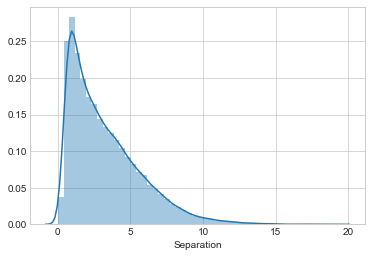

In [8]:
# How Normally Distributed is our Output Variable (Separation)

plt.style.use('seaborn-whitegrid')
Fig = sns.distplot(df['Separation'])

K = round(stats.kurtosis(df['Separation']),1)
S = round(stats.skew(df['Separation']), 1)
p_value = stats.shapiro(df['Separation'])[1]
    
print('\n')
print('The Kurtosis of the distribution of the target variable is ' + str(K))
print('The Skew of the distribution of the target variable is ' + str(S))

df['Separation'].describe()


As we can see, our data is **skewed to the right**, or positively skewed, making the distribution of Separation noticably non-normal (non-gaussian). 

Based on my understanding of the game of football, the only time we would expect receiver separations to be greater than 10 yards, are in instances where the targeted player is not a current threat to gain yards (passes targeting receivers behind the line of scrimmage) OR blatant busts in coverage.

Since the distribution of Separation is so skewed to the right, I decided to use the Tukey method (Tukey JW., 1977) to detect ouliers, which is based on quartiles as opposed to using standard deviations or anything of the like. First we find the interquartile range, comprised between the 1st and 3rd quartile of the distribution (IQR). An outer fence outlier is any Separation value outside the IQR +/- 1 outlier steps. 1 Outlier step is defined as 3 times the interquartile range.

In this case, the only outliers exist beyond the 3rd Quartile (because there are no outliers below Q1), which is **14.5 yards**. 

Since we do not want to predict a receiver will be faced with 'busted' coverage, I will now drop all rows with a separation value above 14.5 yards. 

In [9]:
# 1st quartile (25%)
Q1 = np.percentile(df['Separation'], 25)
# 3rd quartile (75%)
Q3 = np.percentile(df['Separation'],75)
# Interquartile range (IQR)
IQR = Q3 - Q1
        
# outlier step
outlier_step = 3 * IQR

#Upper outer fence
outlier_step + Q3

#Tukey's Outer Upper Fence
Upper_Fence = outlier_step + Q3
Upper_Fence

14.478175490000002

In [10]:
df = df[df['Separation'] <= Upper_Fence]

In [11]:
left = len(df)
print('We dropped ' + str(53710-left) + ' rows with a separation over 14.5 yards, or ' + str(round(((53710-left)/53710)*100,2) )+'% of our dataset')

We dropped 49 rows with a separation over 14.5 yards, or 0.09% of our dataset


## Missing Values

In [12]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
missing_values_table(Features)

Your selected dataframe has 13 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Cushion,14125,26.3
Receiver_Location,108,0.2


Of the 14125 missing cushion values, how many were from targets from receivers who lined up in the backfield?

In [13]:
Cush = df[df['Cushion'].isna()]
Cush['Receiver_Location'].value_counts()

Backfield    9826
Slot         2739
Tight        1329
Wide          113
Name: Receiver_Location, dtype: int64

In [14]:
Backfield = df[(df['Receiver_Location'] == 'Backfield')][['Cushion', 'Separation']]
print('There were ' + str(len(Backfield)) + ' plays where the player who lined up in the backfield was targeted')
print('The average Cushion of a player who lines up in the Backfield is ' + str(Backfield['Cushion'].mean()))
print('The average Separation of a player who lines up in the Backfield is ' + str(round(Backfield['Separation'].mean(), 2)))


There were 9826 plays where the player who lined up in the backfield was targeted
The average Cushion of a player who lines up in the Backfield is nan
The average Separation of a player who lines up in the Backfield is 4.75


Every target to a player that lined up in the *'Backfield'* in this dataset has a **null cushion value**. This makes sense, as they are far from the line of scrimmage, often behind, or to the side of the QB at the time of snap, and roughly 5-10 yards behind the line of scrimmage when the ball is snapped, making it nearly impossible to determine who is covering them, if anyone specific at all. 

If all of the Backfield targets are missing a cushion value, this means that this type of data is *Missing Not at Random* ([relevant wiki](https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random)). With data that is missing Not at Random, it is not 'ignorable' since removing all of these rows would drastically change the distribution of Separation values. 

That being said, the goal of this project is try to predict a players separation as accurately as possible, and if we remove just the backfield targets, we don't necessarily lose any insight in how to predict Separation for non-backfield targets. 

## Ways to deal with missing Cushion values 
 1. Impute the missing values
     - Replace missing values with a summary statistic (like a mean/median)
         - This would introduce a lot bias into the distribution of Cushion in the whole data set (25% would be one number)
     - Use something like kNN (K-nearest neighbors) or other ML model to predict Cushion 
         - 'Backfield' rows have 0 cushion values
         - We have to use other Features in the dataset to draw from
 2. Remove all rows where the receiver location is 'Backfield' 
     - This will remove ~10,000 rows, losing data is never ideal, but sometimes necessary 
     - Predicting non-backfield targets will likely be more accurate after removing these rows
     - Remember our goal: creating a way to compare receivers
         - Since RBs are the primary receiver out of the backfield, I am not as concerned about their ability to create separation

Let's take a look at the distribution of Separations grouped by Receiver Location to see if they are differences:

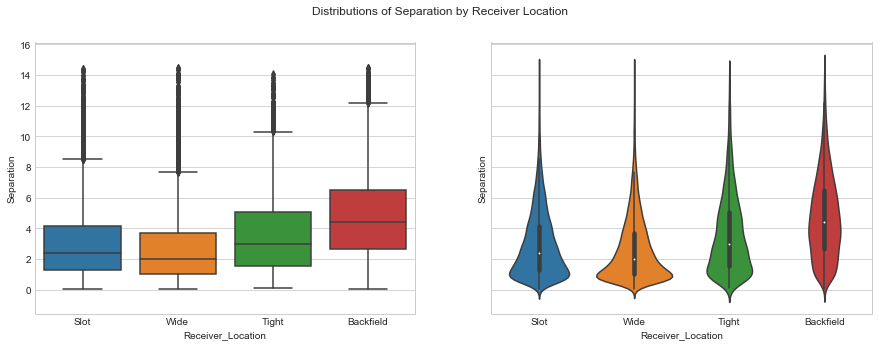

In [15]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

fig.suptitle('Distributions of Separation by Receiver Location')
sns.boxplot(x="Receiver_Location", y="Separation", data=df, ax = ax1)
sns.violinplot(x="Receiver_Location", y="Separation", data=df, ax = ax2)

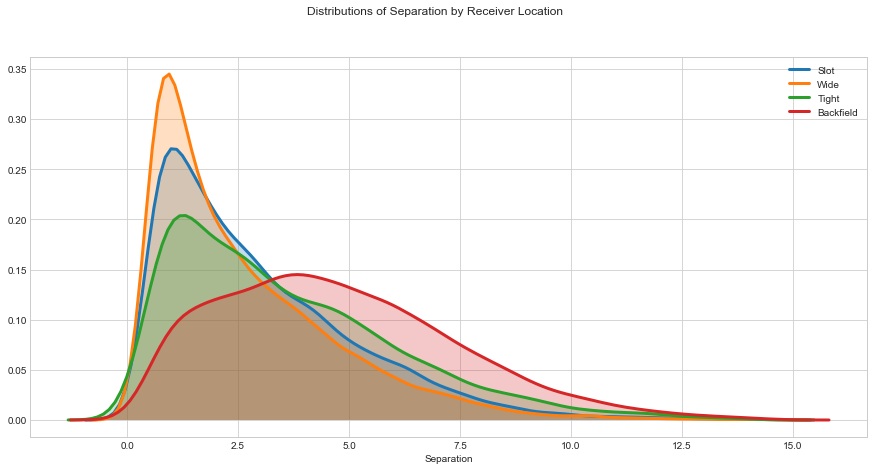

In [16]:
# List of four recevier locations to plot
RecLocations = list(df['Receiver_Location'].unique())

fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Receiver Location')

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    subset = df[df['Receiver_Location'] == loc]
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = loc)
    


In [17]:
print('The mean separation of Backfield targets is ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].std(), 1))+ ' yards')
print('The mean separation of NON-Backfield targets is ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].std(), 1))+ ' yards')

The mean separation of Backfield targets is 4.7 yards, +/- 2.7 yards
The mean separation of NON-Backfield targets is 2.9 yards, +/- 2.2 yards


### Backfield Targets

As we can see, Backfield targets have a **considerably higher** average separation and a distinctly different distribution from non-Backfield targets.

This makes sense, as receivers targeted in the backfield do not have pre-snap cushions, meaning that no one is lined up close to them at the time of snap. Since backfield targets have no one near them at the time of snap, receivers targeted in the backfield are often wide open at the time the pass arrives. This is because the defense either hasn't had enough time to get to the backfield to gaurd the player, or the player does not pose as big of a threat to the defense as the rest of the receivers, so the defense does not guard them as closely. 

Let's check this to see if our assumptions are correct - 

*Are targets to receivers in the backfield shorter (less air yards) and therefore warrant more separation?*



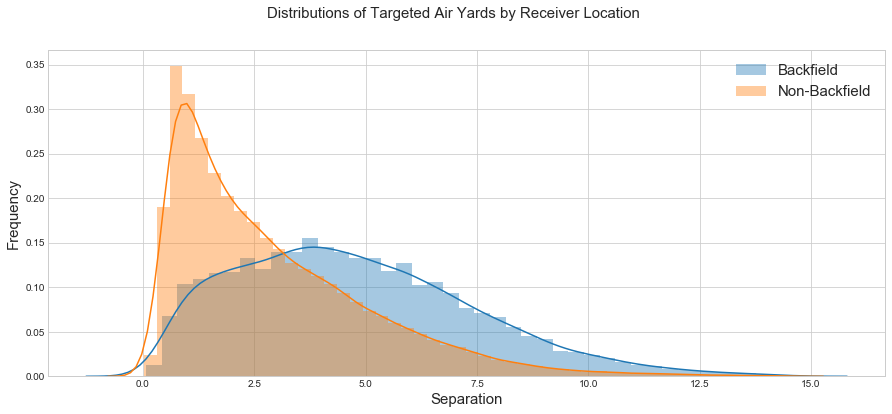

In [18]:
# List of Locations to compare
RecLocations = ['Backfield', 'Non-Backfield']

#Separate dataframes into Backfield and Non-Backfield Dataframes
Bkfd = df[df['Receiver_Location'] == 'Backfield']
NonBkfd = df[df['Receiver_Location'] != 'Backfield']

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Targeted Air Yards by Receiver Location', fontsize = 15)

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    if loc == 'Backfield':
        subset = Bkfd
    else:
        subset = NonBkfd
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, label = loc)
    ax.legend(loc=1, prop={'size': 15})
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel('Separation', fontsize = 15)

In [19]:
print('Average Backfield Target: ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')
print('Average Non-Backfield Target: ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')

Average Backfield Target: 0.04 yards downfield
Average Non-Backfield Target: 10.06 yards downfield


### Dropping all rows for Targets in the Backfield

As we thought, backfield targets are markedly different from non-backfield targets, and exist almost exclusively 5 yards behind (or beyond) the line of scrimmage, while non-backfield targets occur downfield far more frequently. 


Since **all** of the cushion values are missing for targets to recievers who line up in the backfield, and they they usually are not indicative of anything the receiver is inherently doing to create separation, I am choosing to drop all rows targeting receivers who line up in the 'Backfield'

In [20]:
NB_Features = Features[Features['Receiver_Location'] != 'Backfield']
print(len(NB_Features))
missing_values_table(NB_Features)

43864
Your selected dataframe has 13 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Cushion,4279,9.8
Receiver_Location,108,0.2


## Drop all Missing Receiver Location Rows

Since the Missing Receiver_Locations represent ~0.2% of our data set, we can comfortably drop those offending rows.

In [21]:
NB_Features = NB_Features[NB_Features['Receiver_Location'].notnull()]
print(len(NB_Features))
missing_values_table(NB_Features)

43756
Your selected dataframe has 13 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Cushion,4190,9.6


We are left with 4190 misssing cushion values. 

These missing values, unlike the missing cushion values for 'Backfield' Targets, are *'missing at random'*. There is nothing in the dataset that would indicate that these cushions can be inferred from another feature, so I want to look into a way to impute these values effectively and efficiently. 

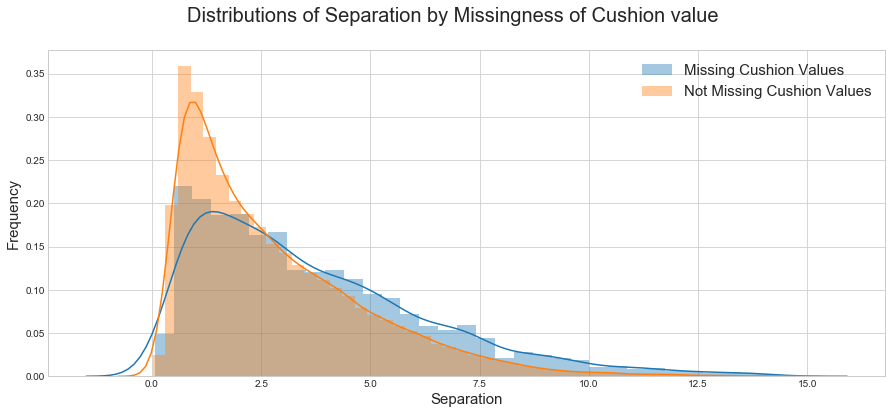

In [22]:
# List of two types of data to plot
DataTypes = ['Missing Cushion Values', 'Not Missing Cushion Values']

#Create dataframe with just non-Backfield targets
df_1 = df[df['Receiver_Location'] != 'Backfield']

#Separate dataframes into missing and non-missing Dataframes
M = df_1[df_1['Cushion'].isna()]
NM = df_1[df_1['Cushion'].notnull()]

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Missingness of Cushion value', fontsize = 20)

# Iterate through the two datatypes (missing and non-missing)
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing Cushion Values':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, label = loc)
    ax.legend(loc=1, prop={'size': 15})
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel('Separation', fontsize = 15)
    

In [23]:
print('Mean Separation w/ missing Cushion: ' + str(round(M['Separation'].mean(), 2)) + ' yards')
print('Mean Separation w/ non-missing Cushion: ' + str(round(NM['Separation'].mean(), 2)) + ' yards')

Mean Separation w/ missing Cushion: 3.7 yards
Mean Separation w/ non-missing Cushion: 2.81 yards


This makes intuitive sense, as we could imagine that targeting receviers who had no-one lined up across from them at the time of snap might lead to larger separation values. 

Let's look into this a little bit further to confirm our suspicions:

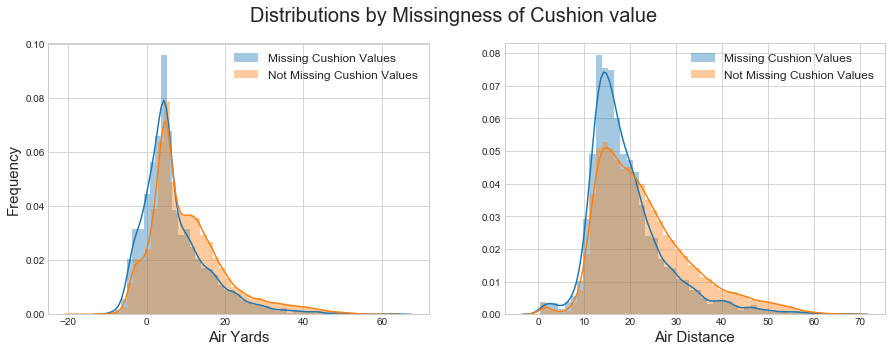

In [24]:
# List of two types of data to plot


fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Distributions by Missingness of Cushion value', fontsize=20)


# Iterate through the four receiver locations
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing Cushion Values':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    sns.distplot(subset['Air_Yds'], ax = ax1, label = loc)
    sns.distplot(subset['Air_Dist'], ax = ax2, label = loc)

    ax1.legend(loc=1, prop={'size': 12})
    ax2.legend(loc=1, prop={'size': 12})
    ax1.set_xlabel('Air Yards', fontsize=15)
    ax2.set_xlabel('Air Distance', fontsize=15)
    ax1.set_ylabel('Frequency', fontsize=15)

In [25]:
Miss = np.array([round(M['Air_Yds'].mean(), 1), round(NM['Air_Yds'].mean(), 1)])
NotMiss = np.array([round(M['Air_Dist'].mean(), 1), round(NM['Air_Dist'].mean(), 1)])
MNS = np.array(['Missing Cushion', 'Not Missing Cushion'])
df_Missingness = pd.DataFrame(); df_Missingness['Avg Air Yards']=pd.Series(Miss) ;df_Missingness['Avg Air Distance']=pd.Series(NotMiss)
df_Missingness['Missingness']=pd.Series(MNS) ;df_Missingness.set_index('Missingness')

,Avg Air Yards,Avg Air Distance
Missingness,,
Missing Cushion,7.2,19.3
Not Missing Cushion,10.4,23.1


When players line up with no cushion, they often are targeted **closer to the line of scrimmage** (7.2 yards downfield vs 10.4) and **closer to where the pass was thrown** (19.3 yards as the crow flies vs. 23.1 yards) 

## Test to see if Distributions are statistically different from each other

We have suspicions that these two samples sets (rows with/without missing Cushion values) are statistically different, but let's confirm this in practice. In order to confirm that these two distributions are statistically different, I run a 2-sample Kolmogorov-Smirnov test [link](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

If, in fact, they are different frmo each other, I must come up with a way to impute them that works to maintain each set's variance and distribution. If they are statistically the same, I can safely remove all offending rows.

In [26]:
from scipy.stats import ks_2samp

p_value = ks_2samp(M['Separation'], NM['Separation'])[1]

print('Our p-value for the K-S test to check for 2-sample similarity is ' + str(p_value))
print('Since our p-value < 0.05, we must find a way to deal with these values, we cannot remove them.')

Our p-value for the K-S test to check for 2-sample similarity is 2.3849552730047203e-72
Since our p-value < 0.05, we must find a way to deal with these values, we cannot remove them.


## Feature Engineering: Missing Cushion

I beleive that the set of receivers who were missing cushion values are so distinct from the non-missing cushion values that their 'missigness' could be insightful tp predicting separation. So, to this end, I will now create a feature called **'missing_cushion'** that is equal to 1 when the playet was missing a cushion value.

In [27]:
# Create new column to indicate plater is missing cushion
NB_Features['missing_cushion'] = 0
NB_Features['missing_cushion'].loc[NB_Features['Cushion'].isna()] = 1
NB_Features['missing_cushion'].sum()

4190

I want to also see if there is a cutoff value where a cushion value is so high, that it behaves like no cushion at all

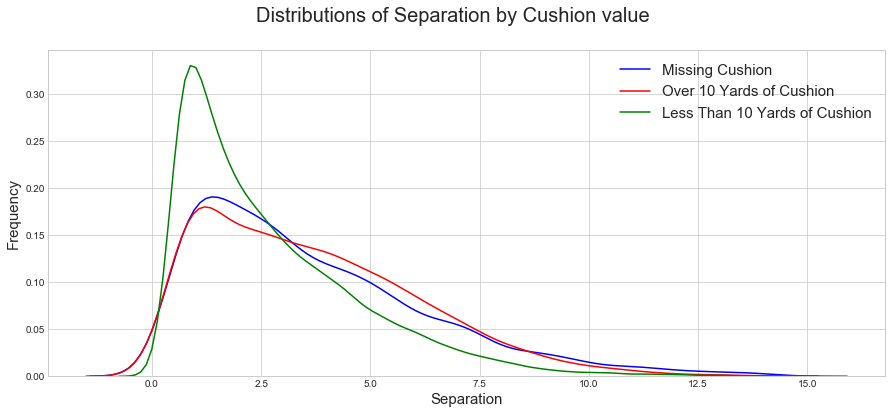

In [28]:
#Create dataframe with just non-Backfield targets
df_1 = df[df['Receiver_Location'] != 'Backfield']

#Separate dataframes into missing and non-missing Dataframes
M = df_1[df_1['Cushion'].isna()]
Over10 = df_1[df_1['Cushion'] >= 10]
Under10 = df_1[df_1['Cushion'] < 10]

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Cushion value', fontsize = 20)

sns.distplot( M['Separation'] , color="blue", label="Missing Cushion", hist = False)
sns.distplot( Over10['Separation'] , color="red", label="Over 10 Yards of Cushion", hist = False)
sns.distplot( Under10['Separation'], color = 'green', label = 'Less Than 10 Yards of Cushion', hist = False)


ax.legend(prop={'size': 15}, )
ax.set_ylabel('Frequency', fontsize = 15)
A = ax.set_xlabel('Separation', fontsize = 15) 

After further inspection, it appears as though **targets with no cushion behave very similarly to targets with 10+ yards of cushion**. Let's do a t-test to see if these two datasets are statistically indiscernable. 

In [29]:
p_value = ks_2samp(M['Separation'], Over10['Separation'])[1]

print('Our p-value for the K-S test to check for 2-sample similarity is ' + str(p_value))
print('Since our p-value > 0.05, it is the case that these two distributions are statistically indiscernable')

Our p-value for the K-S test to check for 2-sample similarity is 1.0
Since our p-value > 0.05, it is the case that these two distributions are statistically indiscernable


## Feature Engineering: Cushion Over 10+ Yards

We have found that not only missing cushion values are statistically significant, but also that when cushion values are greater than 10, the distribution of that variable in relation to the target variable (Separation) behaves like there is a missing cushion value. 

This makes sense intuitively, as the further a defender lines up from a receiver, it is as if there is no one immidiatly defending them. To his end, I will now create another feature called **'missing or 10+ cushion'** that will try to create more insight from the data. 

In [30]:
# Create new column to indicate plater is missing cushion
NB_Features['missing_or_10+_cushion'] = 0
NB_Features['missing_or_10+_cushion'].loc[ (NB_Features['Cushion'].isna()) | (NB_Features['Cushion'] >= 10)] = 1

#How many targets had Missing Cushion OR a Cushion over 10 yards?
NB_Features['missing_or_10+_cushion'].sum()

7688

### Methods of Imputation

1. Replace all missing Cushion values with a summary statistic (mean/median) of Cushion
    - **Pros**: Simple, understandable, and fast
    - **Cons**: Since we are replacing ~10% of our data, this will severely bias our distribution and negatively affect our train/validation accuracies
2. Single Imputation from Regression (kNN, Neural Networks)
    - **Pros**: Introduces less bias than mean/median imputation, is still relatively simple
    - **Cons**: Slower, still does not generate entries that accurately reflect the distribution of the underlying data
3. Multiple Imputation from Chained Equations (MICE)
    - **Pros**: Most accurate, creates multiple imputations and analyzes pool of possible choice to create imputation
    - **Cons**: Slowest and less simple than single imputation
    
    
I am looking to create the most accurate prediction of Separation as I can, so I am choosing **MICE**. 

MICE can be understood as the following steps:
   1. A simple imputation, which in this case, will be the median, is performed for every missing cushion value in the dataset. These median imputations can be thought of as “place holders.”

   2. The “place holder” mean imputations for one variable (“var”) are set back to missing.

   3. The observed values from the variable “var” in Step 2 are regressed on the other variables in the imputation model, which may or may not consist of all of the variables in the dataset. In other words, “var” is the dependent variable in a regression model and all the other variables are independent variables in the regression model.

   4. The missing values for “var” are then replaced with predictions (imputations) from the regression model. When “var” is subsequently used as an independent variable in the regression models for other variables, both the observed and these imputed values will be used.

   5. Steps 2–4 are then repeated for each variable that has missing data. The cycling through each of the variables constitutes one iteration or “cycle.” At the end of one cycle all of the missing values have been replaced with predictions from regressions that reflect the relationships observed in the data.

   6. Steps 2 through 4 are repeated for a number of cycles, with the imputations being updated at each cycle. At the end of these cycles the final imputations are retained, resulting in one imputed dataset. Generally, ten cycles are performed; however, research is needed to identify the optimal number of cycles when imputing data under different conditions. The idea is that by the end of the cycles the distribution of the parameters governing the imputations (e.g., the coefficients in the regression models) should have converged in the sense of becoming stable.

In [31]:
# Transform Categorical Features to One-Hot Encoded Binary Variables

NB_Features_encoded = pd.get_dummies(NB_Features)

NB_Features_encoded.head()


,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,QBP,Receiver_Dist_From_Sideline,...,Nearest_Def_Position_NT,Nearest_Def_Position_OLB,Nearest_Def_Position_S,Nearest_Def_Position_SAF,Nearest_Def_Position_SS,Nearest_Def_Position_TE,Nearest_Def_Position_WR,Receiver_Location_Slot,Receiver_Location_Tight,Receiver_Location_Wide
0,3,3,9,3.66,24.54,33.119846,1.539,2.084347,0,26.303329,...,0,0,0,0,1,0,0,1,0,0
1,3,1,10,2.66,27.23,37.510450,2.202,1.540033,1,12.303331,...,0,0,0,0,0,0,0,0,0,1
2,3,2,8,10.23,42.88,52.871040,2.633,3.386576,0,17.230000,...,0,0,0,0,0,0,0,0,0,1
3,3,3,8,6.74,39.44,49.233444,3.018,2.814427,0,19.433328,...,0,0,0,0,0,0,0,0,0,1
4,2,1,10,3.23,39.06,46.187710,2.636,1.471224,1,15.103330,...,0,0,0,0,1,0,0,0,0,1


In [32]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

MICE_imputer = IterativeImputer(initial_strategy="median", max_iter = 1000, random_state = random_state)

NB_Features_enc_imp = MICE_imputer.fit_transform(NB_Features_encoded)

Cush_Fill = NB_Features_enc_imp[:,3]
NB_Features['Cushion'] = Cush_Fill

#Check how many null values there are
sum(NB_Features['Cushion'].isna())


0

In [33]:
Merged = NB_Features.copy()
Merged['Separation'] = Output

## Handling Outliers

Looking at the table below, I do not see many outrageous values that would warrant a deeper dive, except for the fact that the 'Air_Time' (time the pass has been launched to pass arrival) column has a minumum value of -0.167. Obviously, time cannot be negative, so I will drop all rows with negative time values. 




In [34]:
Merged.describe()

,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,QBP,Receiver_Dist_From_Sideline,EZ_Dist,missing_cushion,missing_or_10+_cushion,Separation
count,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000
mean,2.569796,1.950407,8.850809,6.347676,10.076165,22.743149,1.092692,3.048941,0.205526,13.078713,38.457193,0.095758,0.175702,2.899077
std,1.125045,0.848593,3.959485,3.207376,9.871677,10.121430,0.570437,1.297303,0.404090,7.583627,15.301920,0.294263,0.380570,2.231331
min,1.000000,1.000000,1.000000,0.910000,-17.550000,0.555428,-0.167000,0.090554,0.000000,-5.466669,-3.640000,0.000000,0.000000,0.020000
25%,2.000000,1.000000,6.000000,3.210000,3.700000,15.269947,0.697000,2.150581,0.000000,6.280000,28.910004,0.000000,0.000000,1.160657
50%,3.000000,2.000000,10.000000,6.290000,7.460000,20.458699,0.902000,2.905056,0.000000,13.710000,41.430000,0.000000,0.000000,2.278782
75%,4.000000,3.000000,10.000000,8.950000,14.620000,27.795274,1.320000,3.752902,0.000000,19.243330,50.739998,0.000000,0.000000,4.065145
max,5.000000,4.000000,40.000000,20.900000,63.520000,67.877680,4.586000,13.840437,1.000000,26.663330,60.000000,1.000000,1.000000,19.226980


In [35]:
Merged = Merged[Merged['Air_Time'] > 0]
print(len(Merged))
print('Looks like we dropped 6 rows with negative Air Time')

43750
Looks like we dropped 6 rows with negative Air Time


In [36]:
#Bring the Time Feature back, it was dropped earlier to create the imputations
Time_Index = Merged.index
Merged['Time'] = df['Time'][Time_Index]
#Merged.head()
Merged.columns

Index(['Nearest_Def_Position', 'Qtr', 'Down', 'To Go', 'Receiver_Location',
       'Cushion', 'Air_Yds', 'Air_Dist', 'Air_Time', 'QB_Separation', 'QBP',
       'Receiver_Dist_From_Sideline', 'EZ_Dist', 'missing_cushion',
       'missing_or_10+_cushion', 'Separation', 'Time'],
      dtype='object')

# Exploratory Data Analysis

Now the fun begins! We are left with 16 Raw Features and 1 Target Variable, as follows:

### Categories of Features
- **Numerical Variables**
    - *Discrete*
        1. Quarter
        2. Down
        3. Yards to Go
    - *Binary*
        4. Was the QB Pressured? (Boolean)
    - *Continuous*
        5. Pre-Snap Cushion
        6. Air Yards 
        7. Air Distance
        8. Air Time 
        9. TTT (Time to Throw)
        10. QB Separation
        11. Receiver Distance from Sideline at Target
        12. QB Speed at Pass
        13. Distance Receiver is from Back of Endzone
- **Categorical**
    - *Non-Ordinal*
        14. Position of Nearest Defender
        15. Pre-Snap Receiver Location
- **Time Series Data**
    - *DateTime*
        16. Time left in Quarter
        
Lets create a quick correlation heatmap to see how linearly correlated these features are with Receiver Separation:
      

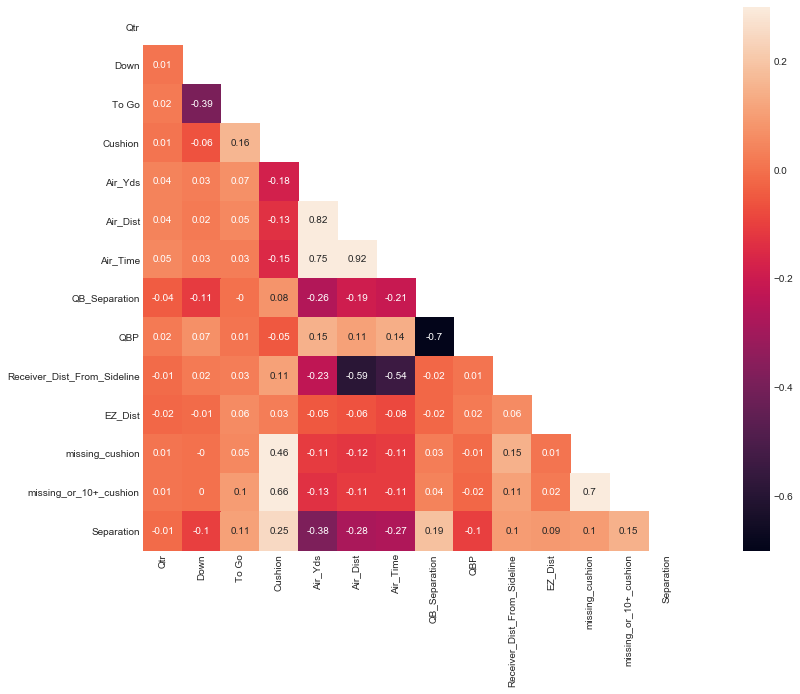

In [37]:
mask = np.zeros_like(Merged.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(round(Merged.corr(method = 'spearman'), 2), mask=mask, vmax=.3, square=True, annot=True, annot_kws={"size": 10})

## Feauture Analysis: Quarter

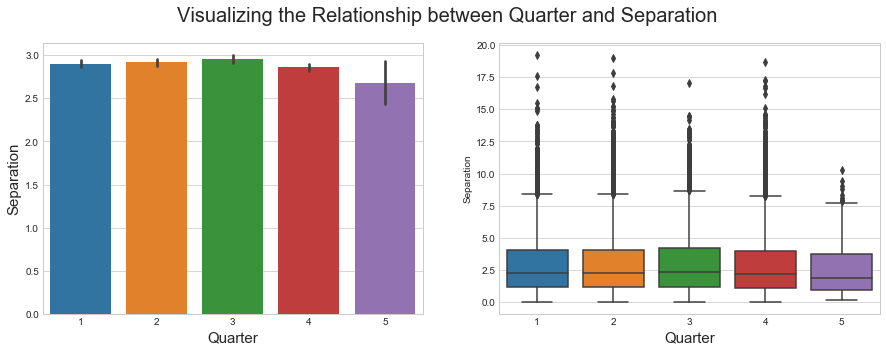

In [38]:
# Show some plots to visualize relationship beteen Quarter and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Quarter and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Qtr', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Qtr', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Quarter', fontsize=15)
ax2.set_xlabel('Quarter', fontsize=15)
A = ax1.set_ylabel('Separation', fontsize=15)

In [39]:
Qtr_df = Merged[['Qtr', 'Separation']]
Qtr_df.groupby(['Qtr']).mean().round({'Separation': 2}).sort_values('Qtr', ascending = True)

,Separation
Qtr,
1,2.90
2,2.91
3,2.95
4,2.85
5,2.68


Just by looking at these distributions, I cannot tell whether quarter has any discernable affect on Separation, especially in the within a regulation game. It looks like passes in Overtime (the 5th quarter) have the lowest average separation, which makes sense, as the stakes are the highest. That said, before I decide to include/remove the feature, I want to run some t-tests to see if the distributions are statistically different from each other. In other words, is the fact that that 3rd quarter has the highest average separation significant? Or could this happen with any random subestting of data? 

## Feature Engineering - 'Is Overtime' 

I am going to separate all regulation Separations (quarters 1-4) with overtime (quarter 5) to see if theres anything there:

Text(0, 0.5, 'Separation')

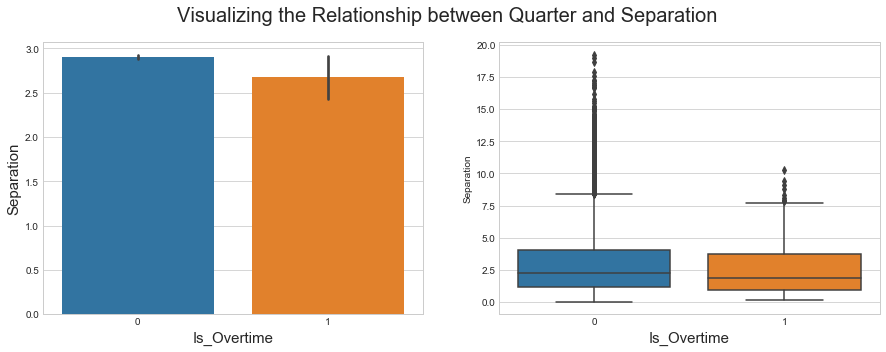

In [40]:
#Create new columns called 'Is_Overtime' that is 1 in overtime and 0 in all other quarter
Merged['Is_Overtime'] = 0
Merged.loc[Merged['Qtr'] == 5, 'Is_Overtime'] = 1

# Show some plots to visualize relationship beteen Quarter and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Quarter and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Is_Overtime', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Is_Overtime', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Is_Overtime', fontsize=15)
ax2.set_xlabel('Is_Overtime', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)


In [41]:
rvs1 = Merged[Merged['Is_Overtime'] == 0]['Separation']
rvs2 = Merged[Merged['Is_Overtime'] == 1]['Separation']

p_value = round(stats.ttest_ind(rvs1,rvs2)[1], 5)

print('Our p value is ' + str(p_value))
print('Since our p value > 0.05, we cannot reject the null hypothesis, making the two disributions statistically similar.')

Our p value is 0.09982
Since our p value > 0.05, we cannot reject the null hypothesis, making the two disributions statistically similar.


Because of this, I will NOT include 'Is_Overtime in my modeling/features selection process.

# Feature Analysis: Down

Text(0, 0.5, 'Separation')

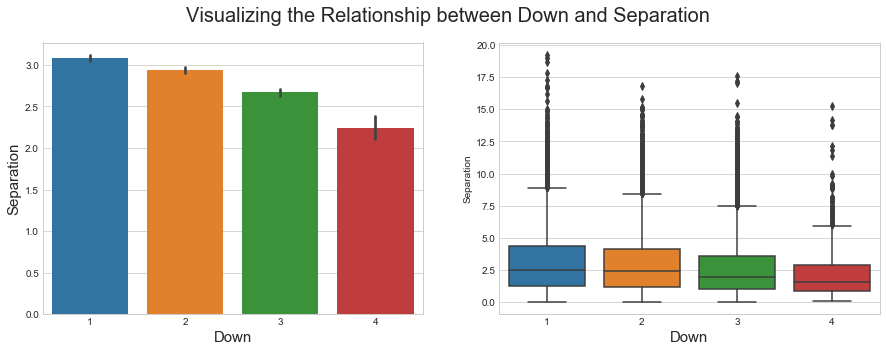

In [42]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Down', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Down', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Down', fontsize=15)
ax2.set_xlabel('Down', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

In [43]:
Down_df = Merged[['Down', 'Separation']]
Down_df.groupby(['Down']).mean().round({'Separation': 2}).sort_values('Down', ascending = True)

,Separation
Down,
1,3.08
2,2.93
3,2.67
4,2.24


There seems to be a correlation between what down it is and the separation of the targeted receiver. This isn't too surprising, as we would expect defenses to play more tightly in more high-stakes/important downs. 

Nothing more needs to be done here, we will keep Down in the data set and move on.

# Feature Analysis: Yards to Go

Text(0, 0.5, 'Separation')

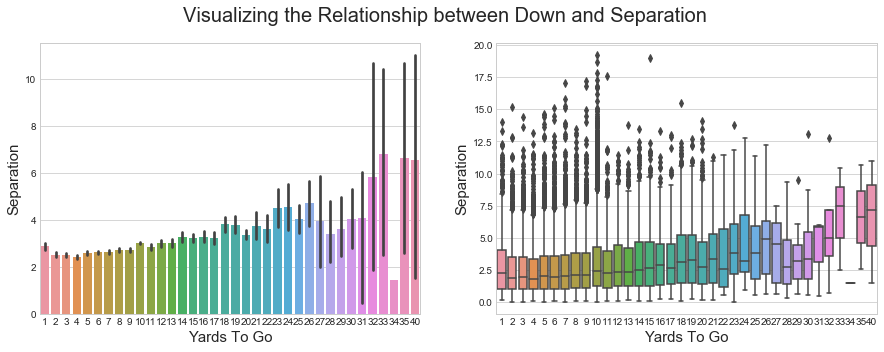

In [44]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='To Go', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='To Go', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Yards To Go', fontsize=15)
ax2.set_xlabel('Yards To Go', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)
ax2.set_ylabel('Separation', fontsize=15)

As we saw above, the correlation coefficient of raw 'Yards To Go' to 'Separation' was 0.11. 

Instead of having 40 unqiue 'To Go' values, I am going to bin certain 'Yards To Go' values into a new category called 'YTG_Bin' or 'Yards To Go Binned.' There will be 4 categories - **Short** (1-4), **Medium** (5-9), **Long** (10), and **Longest** (10+) - in an effort to see if it helps create a higher correlations value or help in predictions. The value of 1 corresponds to Short, and 4 corresponds to Longest.

In [45]:
Merged['YTG_Bin'] = 0

def Create_YTG_Bins(row):
    #Short
    if row <= 4:
        return 'Short'
    
    #Medium
    elif (row >=5 and row <= 9):
        return 'Medium'
    
    #Long
    elif row == 10:
        return 'Long'
    
    #Anything over 10 Yards is Longest!
    elif row > 10:
        return 'Longest'
    
Merged['YTG_Bin'] = Merged['To Go'].apply(Create_YTG_Bins)

In [46]:
YTG_df = Merged[['YTG_Bin', 'Separation']]
YTG_df.groupby(['YTG_Bin']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)

,Separation
YTG_Bin,
Longest,3.26
Long,3.03
Medium,2.68
Short,2.56


Text(0, 0.5, 'Separation')

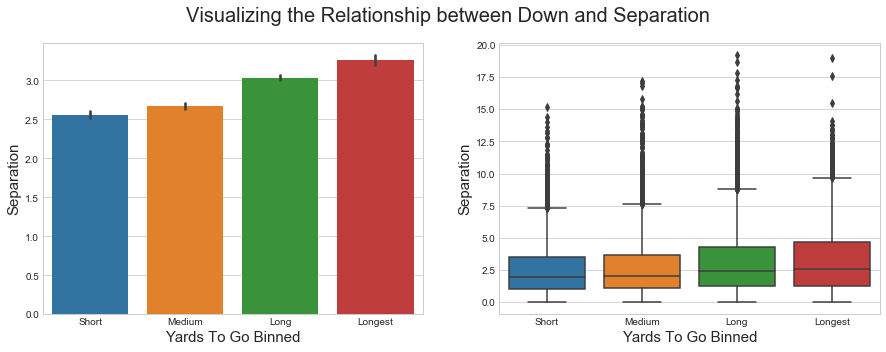

In [47]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

Merged = Merged.sort_values('To Go')

    # Draw the density plots
sns.barplot(x='YTG_Bin', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='YTG_Bin', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Yards To Go Binned', fontsize=15)
ax2.set_xlabel('Yards To Go Binned', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)
ax2.set_ylabel('Separation', fontsize=15)

# Feature Engineering: Down & Distance

Now that we have looked at 'Down' and 'Yards to Go' already, I want to combine them to create a 'Down & Distance' feature. Each of these features alone does not seem to have a lot predictive power, but combined, perhaps they will be more helpful. 

In [48]:
Merged['Down_Distance'] = ''
Merged['Down_Distance'] = Merged['Down'].astype(str) + '&' + Merged['YTG_Bin']
Merged.head()

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,QBP,Receiver_Dist_From_Sideline,EZ_Dist,missing_cushion,missing_or_10+_cushion,Separation,Time,Is_Overtime,YTG_Bin,Down_Distance
18751,DE,4,3,1,Tight,6.360000,1.89,11.663362,0.749,3.294556,0,14.840000,29.110001,0,0,7.146727,8:26,0,Short,3&Short
32194,CB,2,3,1,Wide,6.130000,1.82,17.139150,0.800,3.690908,0,10.150000,55.820000,0,0,2.156154,8:40,0,Short,3&Short
17051,CB,1,3,1,Wide,4.220000,-1.00,12.029235,0.534,2.822144,0,17.083330,20.000000,0,0,5.034014,11:05,0,Short,3&Short
1807,FS,1,3,1,Tight,10.194635,3.12,17.799868,0.858,4.080159,0,10.443331,36.879997,1,1,5.458251,2:01,0,Short,3&Short
46639,CB,4,3,1,Wide,2.000000,34.56,48.004368,2.794,3.241389,0,6.330000,41.439999,0,0,0.254951,2:07,0,Short,3&Short


Text(0, 0.5, 'Separation')

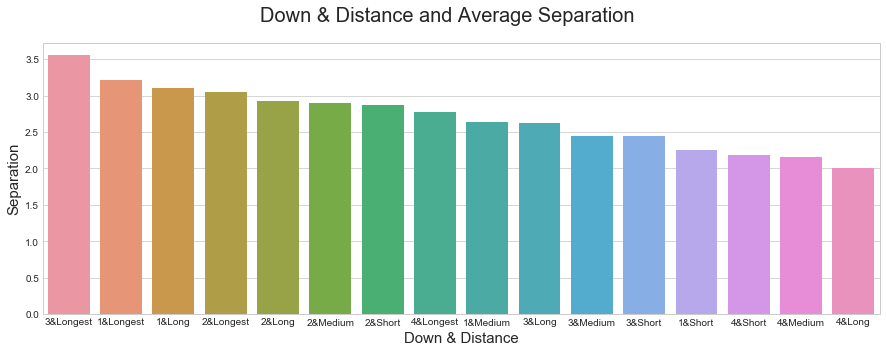

In [49]:
D_D_df = Merged[['Down_Distance', 'Separation']]
dddf = D_D_df.groupby(['Down_Distance']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False).reset_index()
dddf['Play_Counts'] = D_D_df.groupby(['Down_Distance']).count().round({'Separation': 2}).sort_values('Separation', ascending = False)

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Down & Distance and Average Separation', fontsize=20)
sns.barplot(x='Down_Distance', y = 'Separation', data = dddf)

ax.set_xlabel('Down & Distance', fontsize=15)
ax.set_ylabel('Separation', fontsize=15)


# Feature Analysis: Was the QB Pressured?

Text(0, 0.5, 'Separation')

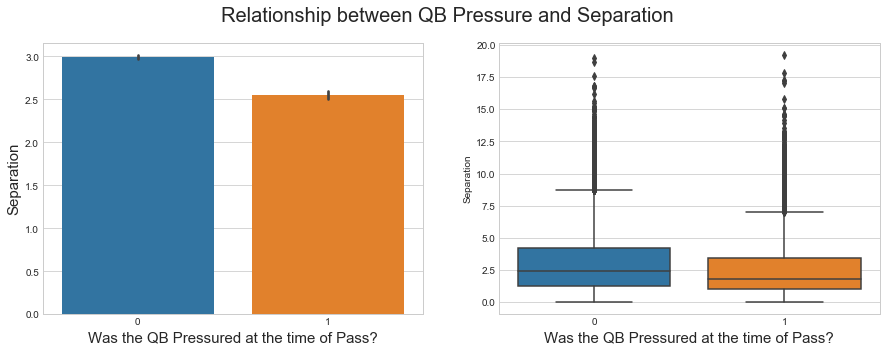

In [50]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Relationship between QB Pressure and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='QBP', y='Separation', data=Merged, ax = ax1) 
sns.boxplot(x='QBP', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Was the QB Pressured at the time of Pass?', fontsize=15)
ax2.set_xlabel('Was the QB Pressured at the time of Pass?', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

As we might expect, when the QB is pressured at the time of pass, receivers gain, on average, 0.5 yards of separation **LESS** than when the QB is kept clean at the time of throw. 

We can keep this feature an move on.

# Feature Analysis: Cushion

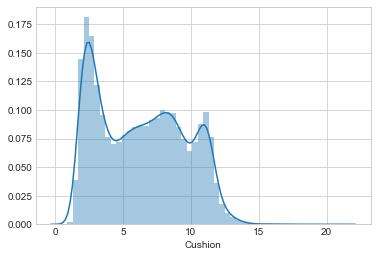

In [51]:
fig = sns.distplot(Merged['Cushion'])

I am noticing the **Trimodal** nature of this distribution, suggesting that defenders usually either line up close to the receiver (think Press coverage), somewhere 4-10 yards off, or very far off of them (or 'Off' coverage). From this, I want to further look into how these three types of cushion relate to the recievers separation

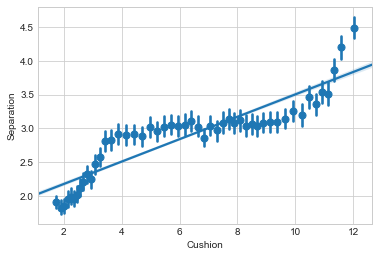

In [52]:
y = Merged['Separation']
x = Merged['Cushion']
p1 = sns.regplot(x=x, y=y, data=Merged, x_bins = 50)

# Feature Engineering: Press, Regular, & Off Coverage

Seen in the binned scatter plot above, we can see that, on the whole, an increase in cushion leads (or at least is linearly correlated to) an increase in separation, up until about 3 yards of cushion. I will create a new feature called 'Press_Cushion' that is equal to 1 when they are 'pressed' at the line of scrimmage (< 3 yards) 0 when lining up 3-10 yards away, and set to 2 when 10+ yards away.

In [53]:
Merged['Press_Cushion'] = 1
Merged['Press_Cushion'].loc[Merged['Cushion'] <= 3] = 0
Merged['Press_Cushion'].loc[Merged['Cushion'] >= 10] = 2
Merged.head() 

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,...,Receiver_Dist_From_Sideline,EZ_Dist,missing_cushion,missing_or_10+_cushion,Separation,Time,Is_Overtime,YTG_Bin,Down_Distance,Press_Cushion
18751,DE,4,3,1,Tight,6.360000,1.89,11.663362,0.749,3.294556,...,14.840000,29.110001,0,0,7.146727,8:26,0,Short,3&Short,1
32194,CB,2,3,1,Wide,6.130000,1.82,17.139150,0.800,3.690908,...,10.150000,55.820000,0,0,2.156154,8:40,0,Short,3&Short,1
17051,CB,1,3,1,Wide,4.220000,-1.00,12.029235,0.534,2.822144,...,17.083330,20.000000,0,0,5.034014,11:05,0,Short,3&Short,1
1807,FS,1,3,1,Tight,10.194635,3.12,17.799868,0.858,4.080159,...,10.443331,36.879997,1,1,5.458251,2:01,0,Short,3&Short,2
46639,CB,4,3,1,Wide,2.000000,34.56,48.004368,2.794,3.241389,...,6.330000,41.439999,0,0,0.254951,2:07,0,Short,3&Short,0


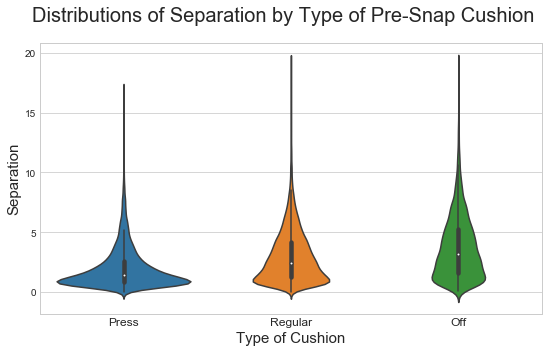

In [54]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig = plt.figure(figsize=(9,5))

sns.violinplot(x="Press_Cushion", y="Separation", data=Merged)

plt.suptitle('Distributions of Separation by Type of Pre-Snap Cushion', fontsize = 20)
plt.ylabel('Separation', fontsize = 15)
plt.xlabel('Type of Cushion', fontsize = 15)

A = plt.xticks([0, 1, 2], ['Press', 'Regular', 'Off'], fontsize = 12)

In [55]:
Pressed = Merged[['Press_Cushion', 'Separation']]
Pressed.groupby(['Press_Cushion']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)

,Separation
Press_Cushion,
2,3.72
1,2.99
0,2.03


Players who were pressed at the line of scrimmage (less than 3 yards of pre-snap cushion) saw **more than a yard of separation less** at pass arrival than receivers who were not pressed. 

Just to confirm, look at the overlayed distributions below to see how the distributions of receivers who are pressed behave differently to those who are not pressed ('Off coverage).

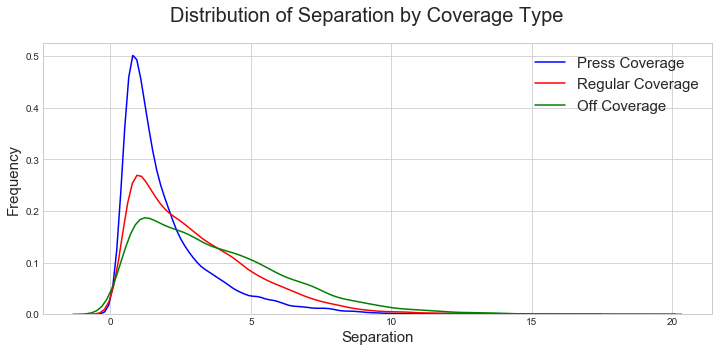

In [56]:
# List of two types of data to plot
Coverage_Types = ['Press Coverage', 'Regular Coverge', 'Off Coverage']

fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distribution of Separation by Coverage Type', fontsize = 20)

sns.distplot( Merged['Separation'].loc[Merged['Press_Cushion'] == 0] , color="blue", label="Press Coverage", hist = False)
sns.distplot( Merged['Separation'].loc[Merged['Press_Cushion'] == 1] , color="red", label="Regular Coverage", hist = False)
sns.distplot( Merged['Separation'].loc[Merged['Press_Cushion'] == 2], color = 'green', label = 'Off Coverage', hist = False)
    
# Draw the density plots
ax.legend(loc=1, prop={'size': 15})
ax.set_ylabel('Frequency', fontsize = 15)
A = ax.set_xlabel('Separation', fontsize = 15)

# Feature Analysis: QB Pressure

Text(0, 0.5, 'Separation')

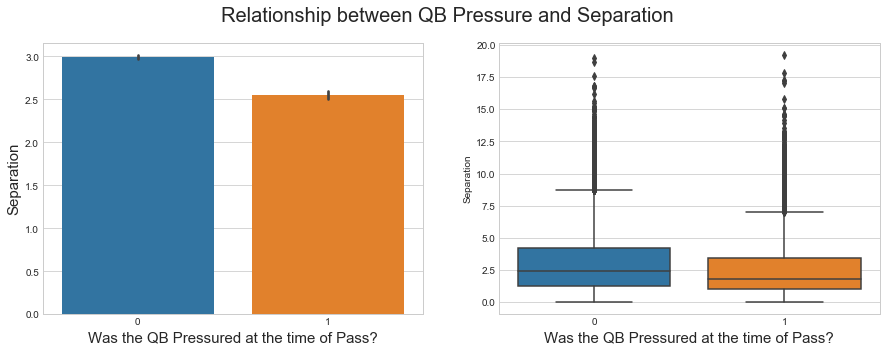

In [57]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Relationship between QB Pressure and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='QBP', y='Separation', data=Merged, ax = ax1) 
sns.boxplot(x='QBP', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Was the QB Pressured at the time of Pass?', fontsize=15)
ax2.set_xlabel('Was the QB Pressured at the time of Pass?', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

# Feature Analysis: Air Distance

Air Distance is the straight line distance from where the ball is thrown to the where the ball is either caught, or the location of the targeted receiver

Text(0.5, 0, 'Air Distance')

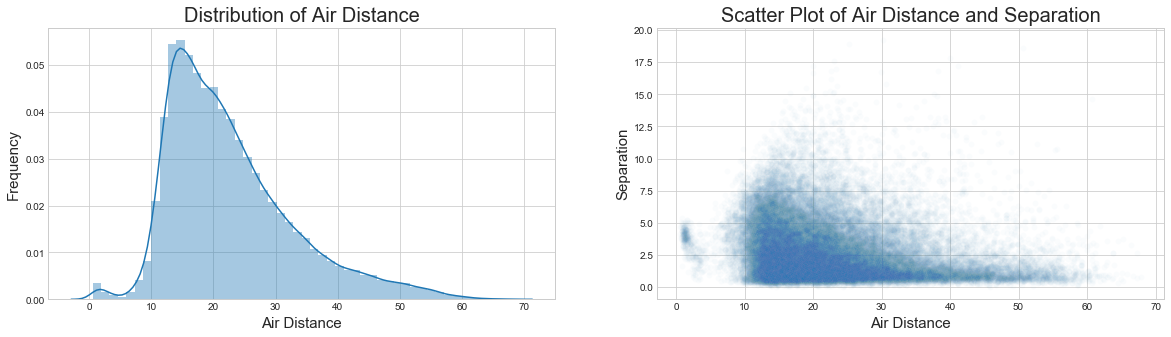

In [58]:
x = Merged['Air_Dist']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Distance', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Distance', fontsize = 15)

ax2.set_title('Scatter Plot of Air Distance and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
ax2.set_xlabel('Air Distance', fontsize = 15)

Text(0.5, 0, 'Air Distance')

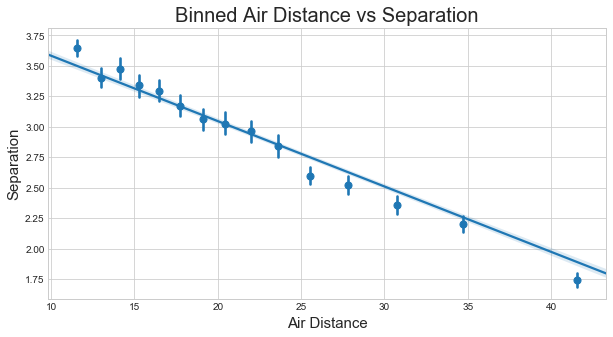

In [59]:
x = Merged['Air_Dist']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 15)

ax.set_title('Binned Air Distance vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
ax.set_xlabel('Air Distance', fontsize = 15)

In [60]:
x.corr(y, method = 'spearman')

-0.2787236499863319

In [61]:
x = Merged['Air_Dist']
y = Merged['Separation']

# Feature Analysis: Air Yards

Air Yards are defined as the distance a pass is from the line of scrimmage, and can be negative if the pass is thrown to a reciever behind the line of scrimmage

Text(0.5, 0, 'Air Yards')

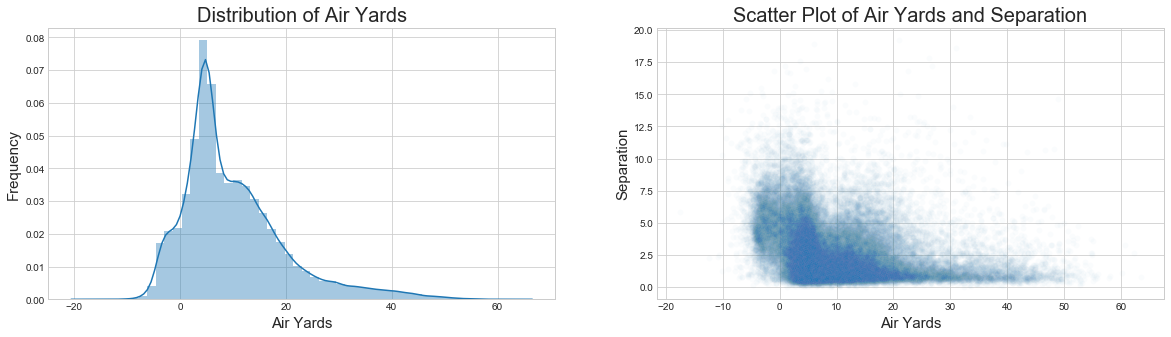

In [62]:
x = Merged['Air_Yds']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Yards', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Yards', fontsize = 15)

ax2.set_title('Scatter Plot of Air Yards and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
ax2.set_xlabel('Air Yards', fontsize = 15)

Text(0.5, 0, 'Air Yards')

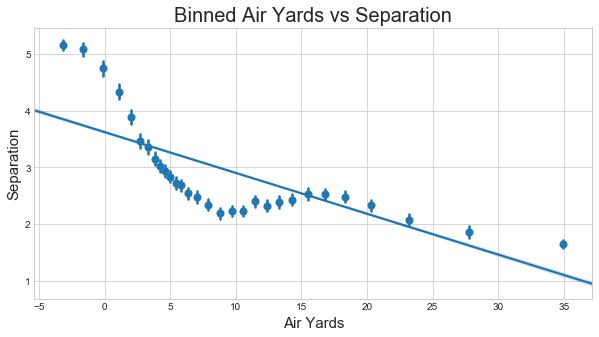

In [63]:
x = Merged['Air_Yds']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('Binned Air Yards vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
ax.set_xlabel('Air Yards', fontsize = 15)

# Feature Analysis: Air Time

Air Time\

What else do I mention here? Is there anything else I can join with Air time?

Text(0.5, 0, 'Air Time')

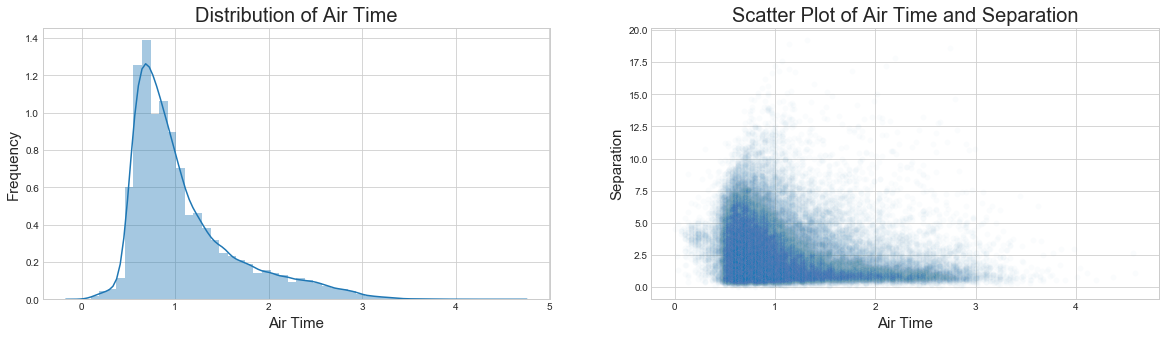

In [64]:
x = Merged['Air_Time']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Time', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Time', fontsize = 15)

ax2.set_title('Scatter Plot of Air Time and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
ax2.set_xlabel('Air Time', fontsize = 15)

In [65]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Air Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Air Time and Separation')

Spearman (rank) correlation: -0.273 between Air Time and Separation
Pearson (linear) correlation: -0.237 between Air Time and Separation


Should I do anything with this scatter plot? What is to be done about these correlation values?

# Feature Analysis: QB Separation


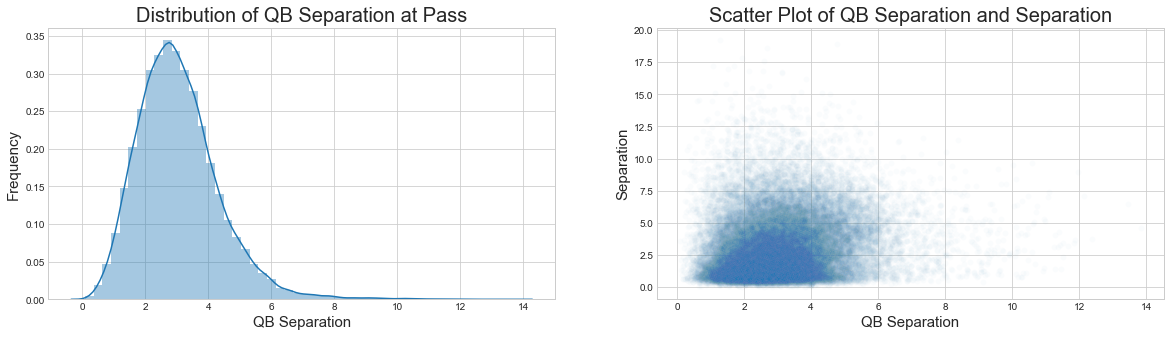

In [66]:
x = Merged['QB_Separation']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of QB Separation at Pass', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('QB Separation', fontsize = 15)

ax2.set_title('Scatter Plot of QB Separation and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Separation', fontsize = 15)

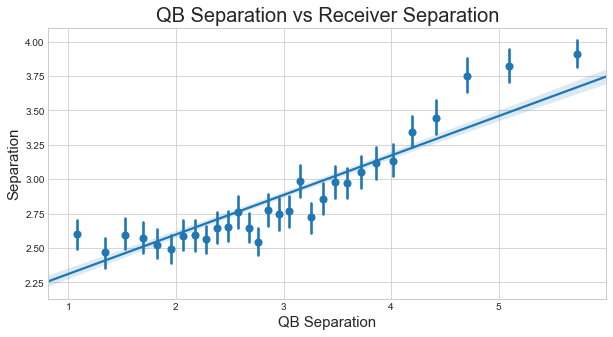

In [67]:
x = Merged['QB_Separation']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('QB Separation vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('QB Separation', fontsize = 15)

# Feature Analysis: Receiver Distance from Sideline as Pass Arrival

This feature quantifies the distance (in yards) from the targeted receiver and the nearest sideline at the time pass arrives. 

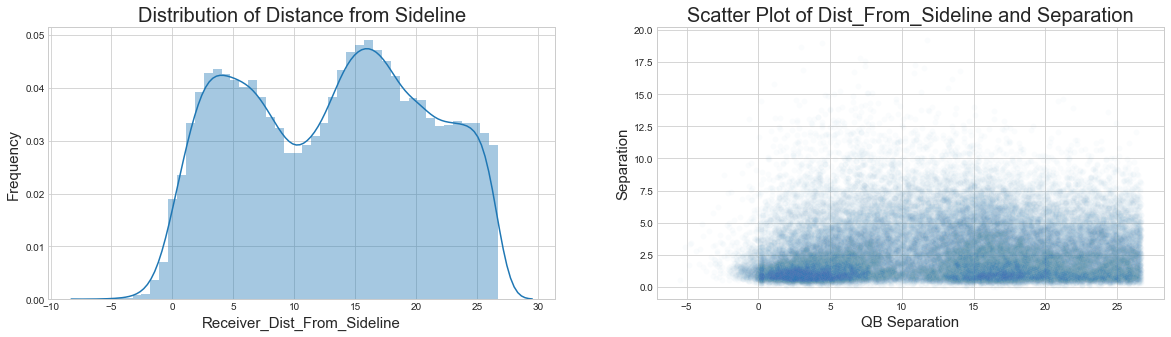

In [68]:
x = Merged['Receiver_Dist_From_Sideline']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Distance from Sideline', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Receiver_Dist_From_Sideline', fontsize = 15)

ax2.set_title('Scatter Plot of Dist_From_Sideline and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Separation', fontsize = 15)

In the graph above, we see the distribution is **bimodal**, with values no greater than 26.66 (exactly at midfield) and going into the negatives. Negative values here indicate that the receiver was out of bounds by the time the pass arrived. 

In [69]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time to Throw and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time to Throw and Separation')

Spearman (rank) correlation: 0.101 between Time to Throw and Separation
Pearson (linear) correlation: 0.068 between Time to Throw and Separation


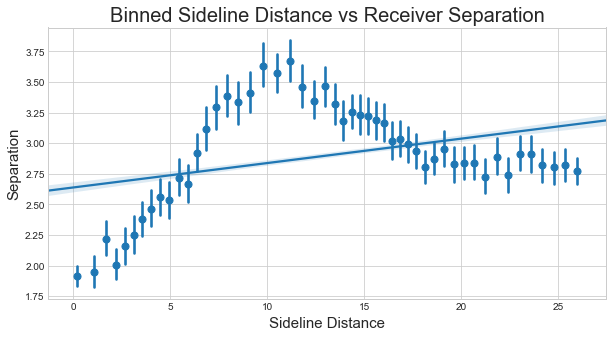

In [70]:
x = Merged['Receiver_Dist_From_Sideline']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 50)

ax.set_title('Binned Sideline Distance vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Sideline Distance', fontsize = 15)

Average Separation decreases steadily once the receiver gets 10 yards away from the sideline. I am going to create a new feature, called 'is_near_sideline' that is binary value (1 or 0) representing when the player is within 5 yards of the sideline to try and distinguish these types of situations.

# Feature Engineering: 'is_near_sideline'

In [71]:
Merged['is_near_sideline'] = 0
Merged['is_near_sideline'].loc[Merged['Receiver_Dist_From_Sideline'] <= 5] = 1
A = Merged['is_near_sideline'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets were within 5 yards of the sideline, or ' + str(C) + ' percent of all plays')

8653 of 43750 targets were within 5 yards of the sideline, or 19.8 percent of all plays


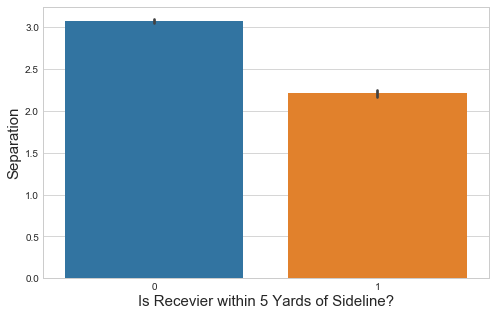

In [72]:
x = Merged['is_near_sideline']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Is Recevier within 5 Yards of Sideline?', fontsize = 15)

# Feature Analysis: Distance Receiver is from Back of Endzone

This feature is defined as the distance (in yards) that there recevier is from the back of the endzone (in the direction the play is facing). 

My initial thought is that this feature will be noise until the receiver gets within some yardage from the back of the endzone, and then get lower as it endzone distance goes to 0. 

For refence, EZ_distance does not get higher than 60 because it is not tracked until a receier crosses midfield (which is 60 yards from back of endzone)

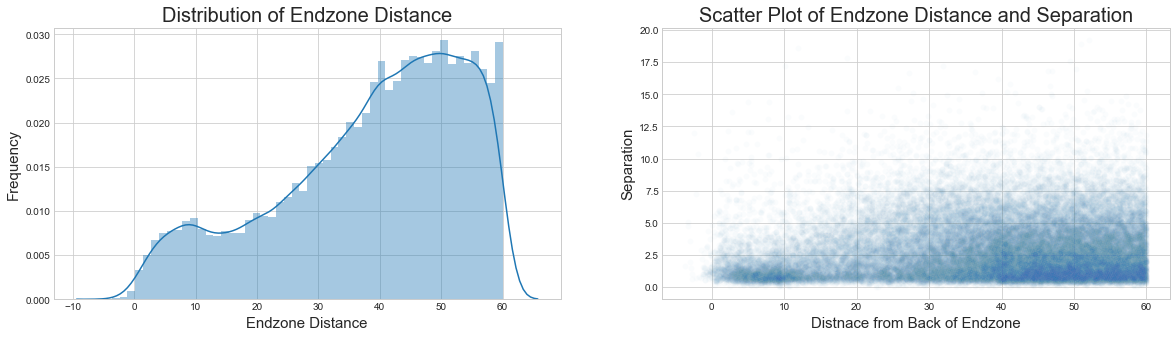

In [73]:
x = Merged['EZ_Dist']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Endzone Distance', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Endzone Distance', fontsize = 15)

ax2.set_title('Scatter Plot of Endzone Distance and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Distnace from Back of Endzone', fontsize = 15)

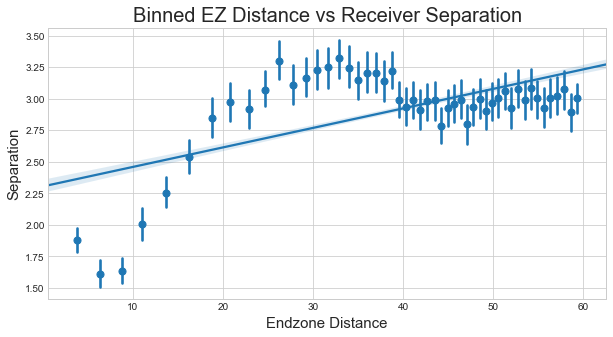

In [74]:
x = Merged['EZ_Dist']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 50)

ax.set_title('Binned EZ Distance vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Endzone Distance', fontsize = 15)

# Feature Engineering: Receiver Within 5 yard line?

Create binary value that is 1 when the target receiver is within 5 yards of the goalline (or 15 yards from the back of the endzone) and 0 everywhere else.

In [75]:
Merged['is_within_5'] = 0
Merged['is_within_5'].loc[Merged['EZ_Dist'] <= 15] = 1
A = Merged['is_within_5'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets were within 5 yards of the goal line, or ' + str(C) + '% of all plays')

4723 of 43750 targets were within 5 yards of the goal line, or 10.8% of all plays


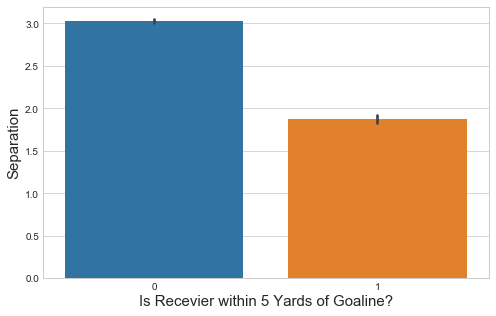

In [76]:
x = Merged['is_within_5']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Is Recevier within 5 Yards of Goaline?', fontsize = 15)

Receivers are allowed _more than yard more_ of separation when they are **NOT** within 5 yards of the goalline (15 yards from the back of the endzone)

# Categorical Features

## Position of Nearest Defender

In [77]:
Pos_df = Merged[['Nearest_Def_Position', 'Separation']]
Position = Pos_df.groupby(['Nearest_Def_Position']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)
Position['Play_Counts'] = Pos_df.groupby(['Nearest_Def_Position']).count()
Position

,Separation,Play_Counts
Nearest_Def_Position,,
DE,5.13,879
NT,5.13,115
DT,5.02,625
DL,4.50,17
OLB,3.69,3333
LB,3.66,1512
MLB,3.36,1519
ILB,3.34,2602
WR,3.01,18


It looks there are a lot of different positions listed here, but 20K plays belong just to CBs. I don't think there is much difference between positions like OLB and ILB, as well as DL vs DE vs DT. To this end, I will consolidate these categories to make it simpler to understand. Also, it looks like a few offensive skill players have been used on defense occasionally. Since they represent ~20 rows, I am going to drop them.

In [78]:
# Dropping all rows where skill position players that were the ones who were the nearest defender at pass arrival
skillpos = ['WR', 'TE', 'FB', 'RB', 'QB']
Merged = Merged[~Merged['Nearest_Def_Position'].isin(skillpos)]

## Feature Engineering: Clean up Defender Position Categories

In [79]:
LB = ['OLB', 'ILB', 'MLB', 'LB']
DL = ['DL', 'DE', 'DT', 'NT']
CB = ['CB', 'DB']
SAFE = ['SAF', 'S', 'FS', 'SS']

def NearestPos(row):
    
    #LBs
    if row in LB:
        return 'LB'
    
    #DLs
    elif row in DL:
        return 'DL'
    
    #CBs
    elif row in CB:
        return 'CB'
    
    #Safeties
    elif row in SAFE:
        return 'STY'
    else:
        return 'Other'
    

Merged['NDP'] = ''
Merged['NDP'] = Merged['Nearest_Def_Position'].copy().apply(NearestPos)    

In [80]:
NDP_df = Merged[['NDP', 'Separation']]
Pos = NDP_df.groupby(['NDP']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)
Pos['Play_Counts'] = NDP_df.groupby(['NDP']).count()
Pos

,Separation,Play_Counts
NDP,,
DL,5.08,1636
LB,3.53,8966
STY,2.90,8199
CB,2.53,24928


# Feature: Pre-Snap Receiver Location

This is what we covered a bit in earlier analysis, but this is broken down into 3 (previously 4, before _backfield_ was removed) categories:
- Wide
- Slot
- Tight

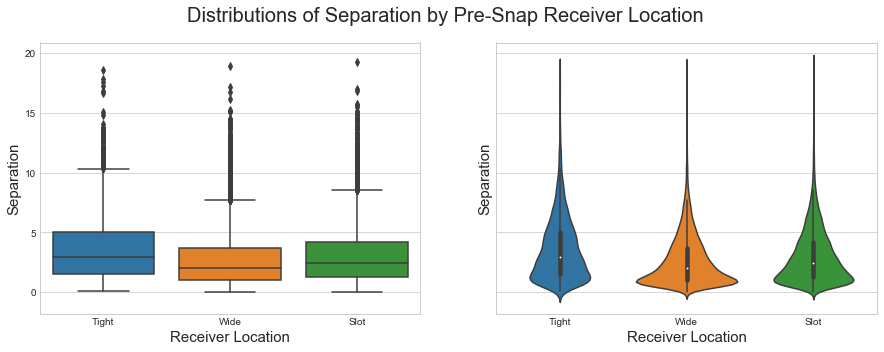

In [81]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))


sns.boxplot(x="Receiver_Location", y="Separation", data=Merged, ax = ax1)
sns.violinplot(x="Receiver_Location", y="Separation", data=Merged, ax = ax2)

fig.suptitle('Distributions of Separation by Pre-Snap Receiver Location', fontsize = 20)
ax1.set_ylabel('Separation', fontsize = 15)
ax1.set_xlabel('Receiver Location', fontsize = 15)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Receiver Location', fontsize = 15)

There are marginal differences between the distributions of these three locations, and I am going to leave them as-is. 

# Feature Analysis: Time

There are 60 minutes in an NFL football game, and I don't think there is any inherent difference that we should expect when it comes to separation when its the start of the 1st, 2nd, 3rd, or 4th quarter. I think there might be more interesting things to find, but I want to translate this MM:SS time string that I am given to an integer value of seconds left in game, and go from there.

In [82]:
def time_to_seconds(time_str):
    #Change the string 'Time' to a value in seconds
    
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

#Quick check to make sure this function does what I am intending
print(str(Merged['Time'][3]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][3])) + ' seconds')
print(str(Merged['Time'][50]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][50])) + ' seconds')
print(str(Merged['Time'][302]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][302])) + ' seconds')

6:45 is equal to 405 seconds
10:29 is equal to 629 seconds
13:46 is equal to 826 seconds


I found a bug with the function, because it didn't know how to treat 'nan' Time values. These were not found earlier because they are 'non as strings, not the Nans that pandas recognizes. Let's remove them now

In [83]:
Merged['Time'] = Merged['Time'].astype(str)
Merged = Merged[Merged['Time'] != 'nan']

In [84]:
Merged['Time_in_Sec'] = Merged['Time'].apply(time_to_seconds)

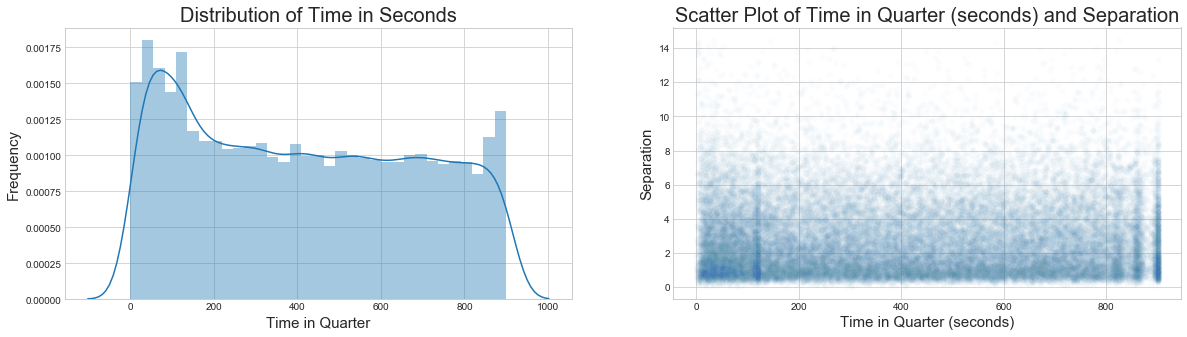

In [85]:
x = Merged['Time_in_Sec']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time in Seconds', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time in Quarter', fontsize = 15)

ax2.set_title('Scatter Plot of Time in Quarter (seconds) and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time in Quarter (seconds)', fontsize = 15)

In [86]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time and Separation')

Spearman (rank) correlation: 0.021 between Time and Separation
Pearson (linear) correlation: 0.015 between Time and Separation


As you might've guessed, the time left in a quarter has almost no correlation to the separation. 

Let's do some feature engineering to see if we can get some more insight out of this feature.

# Feature Engineering: Time Left in Game/Time Left in Half

Its not enough to use just the time left in the quarter to understand how time left affects gameplay, especially receiver separation. Let's see if include Quarter into this measurement helps us understand more.

In [87]:
Merged['sec_left_in_game'] = Merged['Time_in_Sec'] + ((4-Merged['Qtr'])*15*60)


#Check to see that this is doing what we are expecting

print(str(Merged['Time'][3]) + ' in the ' + str(Merged['Qtr'][3]) + 'rd Quarter is equal to ' + str(Merged['sec_left_in_game'][3]) + ' seconds')
print(str(Merged['Time'][30]) + ' in the ' + str(Merged['Qtr'][30]) + 'th Quarter is equal to ' + str(Merged['sec_left_in_game'][30]) + ' seconds')
print(str(Merged['Time'][302]) + ' in the ' + str(Merged['Qtr'][302]) + 'st Quarter is equal to ' + str(Merged['sec_left_in_game'][302]) + ' seconds')

6:45 in the 3rd Quarter is equal to 1305 seconds
7:24 in the 4th Quarter is equal to 444 seconds
13:46 in the 3st Quarter is equal to 1726 seconds


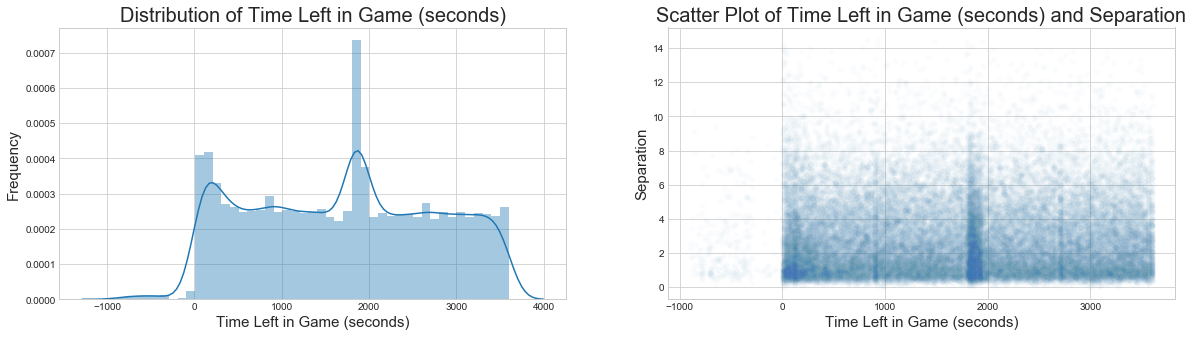

In [88]:
x = Merged['sec_left_in_game']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time Left in Game (seconds)', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time Left in Game (seconds)', fontsize = 15)

ax2.set_title('Scatter Plot of Time Left in Game (seconds) and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time Left in Game (seconds)', fontsize = 15)

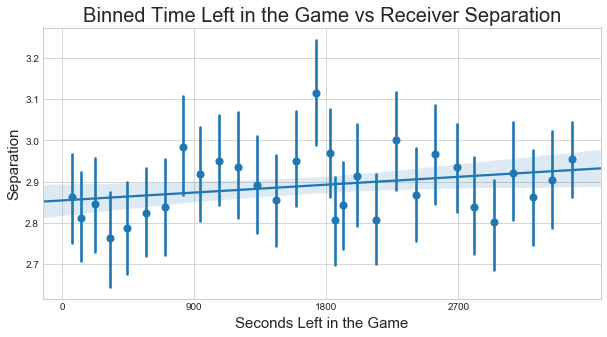

In [89]:
x = Merged['sec_left_in_game']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('Binned Time Left in the Game vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
plt.xticks(np.arange(0, 3600, step=900))
A = ax.set_xlabel('Seconds Left in the Game', fontsize = 15)

I cannot see any strong trends from the graph above, so let me take this a step further, by isolating time by halves.

## Feature Engineering: Time Left in Half

I would like to see if theres anything to the fact that 2 minute scenarios (ends of each half) might be more telling. I suspect that creating a new field called **_'time left in half'_** might be more insightful

In [90]:
mask = (Merged['Qtr'] == 1) | (Merged['Qtr'] == 3)
Merged['sec_left_in_half'] = Merged['Time_in_Sec']
Merged['sec_left_in_half'][mask] = Merged['Time_in_Sec'] + 900
Merged.head() 

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,...,Is_Overtime,YTG_Bin,Down_Distance,Press_Cushion,is_near_sideline,is_within_5,NDP,Time_in_Sec,sec_left_in_game,sec_left_in_half
18751,DE,4,3,1,Tight,6.360000,1.89,11.663362,0.749,3.294556,...,0,Short,3&Short,1,0,0,DL,506,506,506
32194,CB,2,3,1,Wide,6.130000,1.82,17.139150,0.800,3.690908,...,0,Short,3&Short,1,0,0,CB,520,2320,520
17051,CB,1,3,1,Wide,4.220000,-1.00,12.029235,0.534,2.822144,...,0,Short,3&Short,1,0,0,CB,665,3365,1565
1807,FS,1,3,1,Tight,10.194635,3.12,17.799868,0.858,4.080159,...,0,Short,3&Short,2,0,0,STY,121,2821,1021
46639,CB,4,3,1,Wide,2.000000,34.56,48.004368,2.794,3.241389,...,0,Short,3&Short,0,0,0,CB,127,127,127


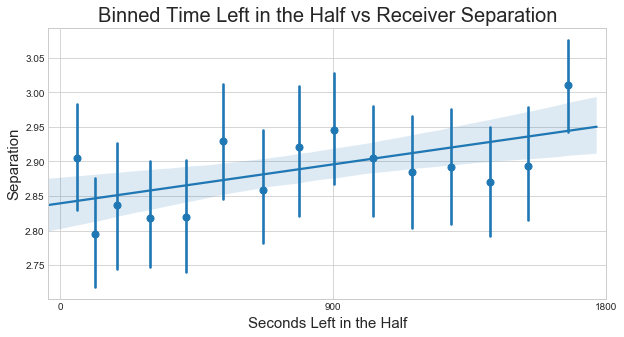

In [91]:
x = Merged['sec_left_in_half']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y,  x_bins = 15)

ax.set_title('Binned Time Left in the Half vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
plt.xticks(np.arange(0, 2700, step=900))
A = ax.set_xlabel('Seconds Left in the Half', fontsize = 15)

In [92]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time and Separation')

Spearman (rank) correlation: 0.023 between Time and Separation
Pearson (linear) correlation: 0.016 between Time and Separation


Turns out, this had little to **no effect** on my correlation values, but so it goes! I am going to try one more thing to see if it is potentially helpful. I am going to create a boolean for 'is_under_2_min' that checks whether the play comes with under 2 minuets left in the half.

## Feature Engineering: 2-Minute Drill? 

Does the pass come with under 2 minutes left in a half?

In [93]:
Merged['Under_2Min'] = 0
Merged['Under_2Min'].loc[Merged['sec_left_in_half'] <= 120] = 1

A = Merged['Under_2Min'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets came with under 2 min remaining in the half, or ' + str(C) + '% of all plays')

6301 of 43699 targets came with under 2 min remaining in the half, or 14.4% of all plays


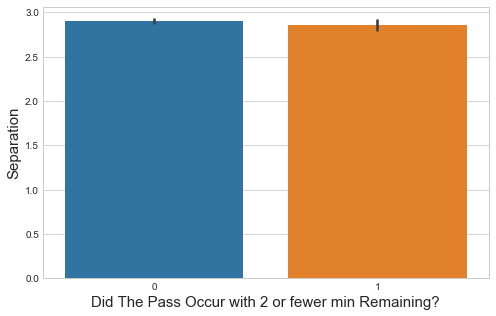

In [94]:
x = Merged['Under_2Min']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Did The Pass Occur with 2 or fewer min Remaining?', fontsize = 15)

Even after doing this work, unfortunately, **being under 2 min left in the half has almost no correlation** to receiver separation. 

# Feature Selection

We started with 16 raw feaures in the dataset, and we engineered 14 more features with the prosect of trying to create more insightful variables. Now with 30 features to sift through, let's dive in to the process of selecting the features that account for the most variance in the output variable (*Receiver Separation*)

I would like to note that it would be perfectly fine to use all 30 features and see how it all turns out, but when potentially dealing with linear regression modeling we should be wary that including unessary, co-variate, or redundant features would only cloud our predictions.

> _Many models, especially those based on regression slopes and intercepts, will estimate parameters for every term in the model. Because of this, the presence of non-informative variables can add uncertainty to the predictions and reduce the overall effectiveness of the model._
>
> Page 488, Applied Predictive Modeling, 2013.

In [95]:
#Time is a string, we don't need it now that we have it in seconds, let's drop it
Merged = Merged.drop('Time', axis = 1)
Merged = Merged.drop('Time_in_Sec', axis = 1)
Merged = Merged.drop('Nearest_Def_Position', axis = 1)

In [96]:
#Check to see how many null values there are left
Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43699 entries, 18751 to 46508
Data columns (total 25 columns):
Qtr                            43699 non-null int64
Down                           43699 non-null int64
To Go                          43699 non-null int64
Receiver_Location              43699 non-null object
Cushion                        43699 non-null float64
Air_Yds                        43699 non-null float64
Air_Dist                       43699 non-null float64
Air_Time                       43699 non-null float64
QB_Separation                  43699 non-null float64
QBP                            43699 non-null int64
Receiver_Dist_From_Sideline    43699 non-null float64
EZ_Dist                        43699 non-null float64
missing_cushion                43699 non-null int64
missing_or_10+_cushion         43699 non-null int64
Separation                     43699 non-null float64
Is_Overtime                    43699 non-null int64
YTG_Bin                        43699 n

### Handling Skewed Features/Log/Cube Root Transform

For linear models, an assumption that we make is that the features we select have a linear relationshup to the target variable. (Separation). Unfortunately, a lot of the features in my dataset do not relate to separation linearly. So, to encourage this behavior, we will apply a log transform to the skewed features, so that they behave more linearly in relation to out target variable. 

In fact, we will be using the log1p() NumPy funciton which adds 1 to every element of the feature before taking the log of it so that there are no errors at 0. Also, I noticed after trying to fit this model to a basic linear regression that the residuals were not normally distributed and that the I was often overpredicting separation. In response, I will apply a **cube root transformation** to account for this non-gaussian behavior. I chose a cube root transform for Separation specifically because it performed better at creating a more normal distribution than the log transform. 

In [97]:
#Make a copy of the dataframe
Merged_T = Merged.copy()

#log transform skewed numeric floating point (continuous) features:
float_cols = Merged_T.drop('Separation', axis =1).select_dtypes(include=['float64'])
float_cols = float_cols.columns

skewed_feats = Merged_T[float_cols].apply(lambda x: stats.skew(x)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > .50]
skewed_feats = skewed_feats.index

print('There are ' + str(len(skewed_feats)) + ' skewed features that needed to be log transformed')
print('The Skewed features were ' + str(list(skewed_feats)))

# Air Yards needs to be shifted before we log transform

Merged_T['Air_Yds'] = Merged_T['Air_Yds'] + 20

#Apply log(1+x) transform to all feaures with skewed distributions

Merged_Trans = Merged_T.copy()
Merged_Trans[skewed_feats] = np.log1p(Merged_Trans[skewed_feats])

There are 4 skewed features that needed to be log transformed
The Skewed features were ['Air_Yds', 'Air_Dist', 'Air_Time', 'QB_Separation']


In [98]:
Merged_Trans[skewed_feats].describe()

,Air_Yds,Air_Dist,Air_Time,QB_Separation
count,43699.000000,43699.000000,43699.000000,43699.000000
mean,3.391879,3.078922,0.706606,1.349008
std,0.292590,0.431960,0.243523,0.316651
min,1.238374,0.441751,0.003992,0.086686
25%,3.207208,2.789208,0.528862,1.147661
50%,3.348500,3.065984,0.642380,1.362393
75%,3.572907,3.360142,0.841136,1.558745
max,4.436988,4.232332,1.720263,2.697356


In [99]:
float_cols

Index(['Cushion', 'Air_Yds', 'Air_Dist', 'Air_Time', 'QB_Separation',
       'Receiver_Dist_From_Sideline', 'EZ_Dist'],
      dtype='object')

## Encoding Categorical Variables

Before we can start doing any worthwhile analysis, we have to encode our categorical variables into numerical ones so our linear/ML models can begin to understand what they represent. To do this, we will **1-HOT ENCODE** all our categorical variables, creating a new column for each possible value within each category. This isnt necessarily the most effective or accurate way to encode our variables, but it is tried and true, and creates a good baseline. If we want to ensure no stone is unturn later, we can revisit other ways to encode each categorical variable.

In [100]:
# One Hot Encodes all labels before Machine Learning

Merged_Enc = pd.get_dummies(data = Merged_Trans)

## Train/Test Split

Before we start our analysis, we must split our data into a Training set and a Test set. We do this so that during our model fitting process, we do no overfit, and cause our model to become less accurate when seeing new data. 

In [101]:
from sklearn.model_selection import train_test_split

# Split data into 80% Training, 20% Test data. 
# We won't touch the Test data until after we have chosen our features and modeled/fit our training set
X = Merged_Enc.copy().drop('Separation', axis=1)
y = Merged_Enc.copy()['Separation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state) # 0.2 test_size means 20%

X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = random_state) # 0.2 test_size means 20%

#Split X_Train in Validation Set
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_2.shape, X_val.shape, y_train_2.shape, y_val.shape

((34959, 47),
 (8740, 47),
 (34959,),
 (8740,),
 (31463, 47),
 (3496, 47),
 (31463,),
 (3496,))

<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' alt="Drawing" style="width: 450px;"/>

## Model Evaluation Prodecedure

The evaluation process for seeing how accurate my predictions are will be based on **MEAN ABSOLUTE ERROR**:

The reason that I am choosing Mean Absolute Error over more well-used errors like Root Mean Sqaured Error is because we do NOT want to penalize the model when predictions are way off. For example, if the model predicts 4 yards of separation, but there ends up being 15 yards of separation (blown coverage), I don't want the model to overreact and try to fit to that point, I'd rather create a more conservative model.

In [102]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# The error metric: Mean Absolute Error
def CV_MAE(model, X, y):
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=10)
    return (mae)

# Model Selection

Since the output of this model will be presented to Fans/General Mangers/Scouts alike, I think it very important that the model I design to be as simple, and as easy to understand as possible. To this end, I will test a few different linear regressors out, as well as some other ensemble ML models (XGBoost, LGBM, GBR) and see if there is a large discrepancy in model performance. Usually, the more complex, black box ensemble models will perform better, but if the difference isn't too large, I will prefer to use a simpler linear model instead to improve acceptance and comprehensability. 

In [103]:
from sklearn.preprocessing import StandardScaler

# Scale Continuous independent variables (input features)
Scaler = StandardScaler()

X_train[float_cols] = Scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = Scaler.fit_transform(X_test[float_cols])
X_train_2[float_cols] = Scaler.fit_transform(X_train_2[float_cols])
X_val[float_cols] = Scaler.fit_transform(X_val[float_cols])

In [104]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet, HuberRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#Linear Models
LR = LinearRegression()

#Ridge Regression
Ridge = RidgeCV()

#Lasso Regression
Lasso = LassoCV()

#HuberRegression
Huber = HuberRegressor()

#Ensemble Models
rf = RandomForestRegressor(random_state=random_state)

#eXtreme Gradient Boosting Regressor 
xgb = XGBRegressor(eval_metric='mae', random_state=random_state)

# Light Gradient Boosting Regressor
LGBM = LGBMRegressor(metric = 'mae',random_state=random_state)

## Create Pipeline for scoring/transforming

In [105]:
%%time
#Linear Regression
LR_scores = CV_MAE(LR, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LR_scores.mean()))

Mean Absolute Error -1.456825
CPU times: user 935 ms, sys: 89.4 ms, total: 1.02 s
Wall time: 426 ms


In [106]:
%%time
#Linear Regression
Huber_scores = CV_MAE(Huber, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Huber_scores.mean()))

Mean Absolute Error -1.466409
CPU times: user 21.9 s, sys: 1.84 s, total: 23.8 s
Wall time: 12.5 s


In [107]:
%%time
#CrossValidated Ridge Regression
Ridge_scores = CV_MAE(Ridge, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Ridge_scores.mean()))

Mean Absolute Error -1.456797
CPU times: user 2.82 s, sys: 450 ms, total: 3.27 s
Wall time: 1.43 s


In [108]:
%%time
#Cross-Validated Lasso Regression
Lasso_scores = CV_MAE(Lasso, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Lasso_scores.mean()))

Mean Absolute Error -1.473433
CPU times: user 8.07 s, sys: 977 ms, total: 9.05 s
Wall time: 4.42 s


In [109]:
%%time
#Random Forest Regression
RandomForest_scores = CV_MAE(rf, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * RandomForest_scores.mean()))

Mean Absolute Error -1.457921
CPU times: user 35.6 s, sys: 311 ms, total: 35.9 s
Wall time: 36.1 s


In [110]:
%%time
#eXtreme Gradient Boosted Regression
xgb_scores = CV_MAE(xgb, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * xgb_scores.mean()))

Mean Absolute Error -1.398693
CPU times: user 2min 41s, sys: 1.46 s, total: 2min 42s
Wall time: 48.8 s


In [111]:
%%time
#Light Gradient Boosted Model
LGBM_scores = CV_MAE(LGBM, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LGBM_scores.mean()))

Mean Absolute Error -1.365581
CPU times: user 15.9 s, sys: 553 ms, total: 16.4 s
Wall time: 4.41 s


In [112]:
MAE_error=[LR_scores.mean(),Huber_scores.mean(), Lasso_scores.mean(), RandomForest_scores.mean(),xgb_scores.mean(),LGBM_scores.mean()]

col={'Avg MAE':MAE_error}
models=['Linear Regression','Huber Loss Regression', 'Lasso Regression','Random Forest','XGBoost','Light GBM']
Scoring_df=pd.DataFrame(data=col,index=models)

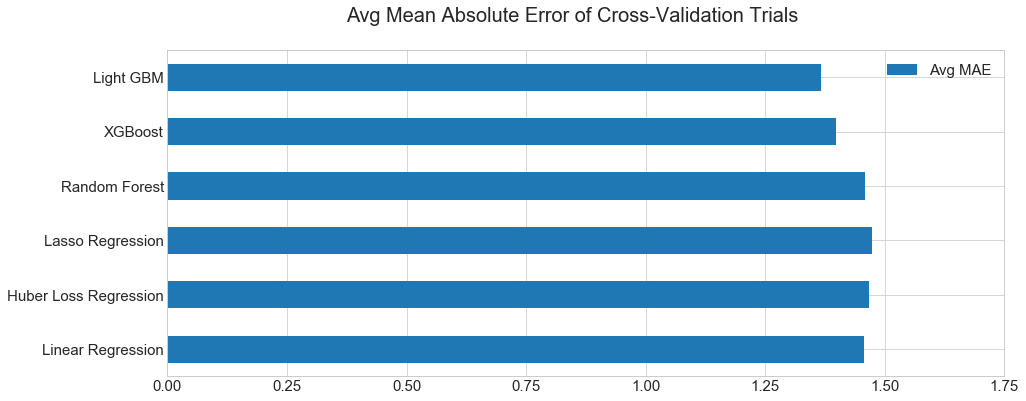

In [113]:
fig, ax = plt.subplots(figsize=(15, 6))
Scoring_df.plot(kind='barh', ax = ax)
ax.tick_params(labelsize=15)
plt.xticks(np.arange(0, 2, step=0.25))
ax.legend( prop={'size': 15})
A = fig.suptitle('Avg Mean Absolute Error of Cross-Validation Trials', fontsize=20)

# Residuals and Results

In [114]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import ValidationCurve

As we can see below, since the distribution of output variable (Separation) is so right skewed it is causing the distribution of our residuals to be skewed as well. In Linear Regression, one of the assumptions we make for our model to be valid is that the residuals are normally distributed. In this case, since the Mean Absolute Error for the Light Gradient Boosted model was the lowest (best), we do not need these assumptions to hold, as this is no longer linear regression.

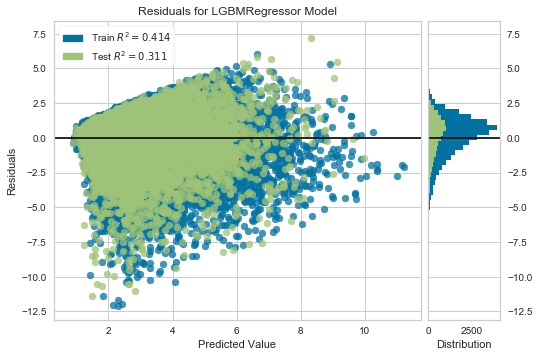

In [115]:
LGBM_fit = LGBM.fit(X_train_2, y_train_2)

visualizer = ResidualsPlot(LGBM_fit)
visualizer.fit(X_train_2, y_train_2)
visualizer.score(X_test, (y_test))
A = visualizer.show()

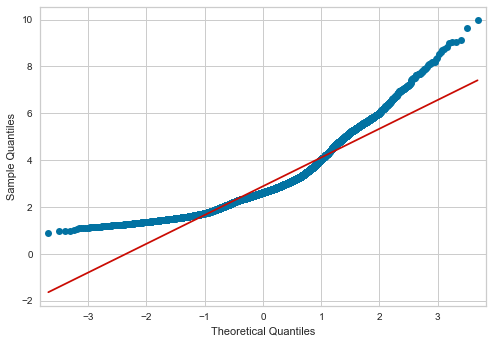

In [116]:
#QQ plot to show distribution of residuals
import statsmodels.api as sm

LGBM_fit.fit(X_train_2, y_train_2)
y_hat = LGBM_fit.predict(X_test)

# Create QQ plot
sm.qqplot(y_hat, line='s')
plt.show()


### Hyperparameter Tuning the Light Gradient Boosted Model

In [117]:
import optuna.integration.lightgbm as lgb
from sklearn.metrics import mean_absolute_error

dtrain = lgb.Dataset(X_train_2, label=y_train_2)
dval = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "regression",
    "metric": "l1",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

model = lgb.train(
    params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=100,
)

prediction = model.predict(X_val, num_iteration=model.best_iteration)
MAE = mean_absolute_error(y_val, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(MAE))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.27438	valid_1's l1: 1.35315
[200]	training's l1: 1.20371	valid_1's l1: 1.35435
Early stopping, best iteration is:
[143]	training's l1: 1.24232	valid_1's l1: 1.35209


feature_fraction, val_score: 1.352088:  14%|#4        | 1/7 [00:01<00:07,  1.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.27918	valid_1's l1: 1.36053
[200]	training's l1: 1.20862	valid_1's l1: 1.35561
Early stopping, best iteration is:
[178]	training's l1: 1.22166	valid_1's l1: 1.35492


feature_fraction, val_score: 1.352088:  29%|##8       | 2/7 [00:02<00:06,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28412	valid_1's l1: 1.35811
[200]	training's l1: 1.21995	valid_1's l1: 1.35298
Early stopping, best iteration is:
[171]	training's l1: 1.23682	valid_1's l1: 1.3515


feature_fraction, val_score: 1.351502:  43%|####2     | 3/7 [00:03<00:04,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.2734	valid_1's l1: 1.35756
[200]	training's l1: 1.20235	valid_1's l1: 1.35493
Early stopping, best iteration is:
[173]	training's l1: 1.21968	valid_1's l1: 1.35395


feature_fraction, val_score: 1.351502:  57%|#####7    | 4/7 [00:05<00:03,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.27569	valid_1's l1: 1.35839
Early stopping, best iteration is:
[84]	training's l1: 1.28919	valid_1's l1: 1.35738


feature_fraction, val_score: 1.351502:  71%|#######1  | 5/7 [00:06<00:02,  1.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.27991	valid_1's l1: 1.35978
[200]	training's l1: 1.21349	valid_1's l1: 1.35959
Early stopping, best iteration is:
[148]	training's l1: 1.24576	valid_1's l1: 1.35785


feature_fraction, val_score: 1.351502:  86%|########5 | 6/7 [00:07<00:01,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.2914	valid_1's l1: 1.36369
[200]	training's l1: 1.2285	valid_1's l1: 1.35943
[300]	training's l1: 1.17774	valid_1's l1: 1.35923
Early stopping, best iteration is:
[253]	training's l1: 1.20043	valid_1's l1: 1.35762


feature_fraction, val_score: 1.351502: 100%|##########| 7/7 [00:08<00:00,  1.25s/it][I 2020-07-14 14:29:59,287] Finished trial#6 with value: 1.3576151469835034 with parameters: {'feature_fraction': 0.4}. Best is trial#2 with value: 1.351502477353886.

num_leaves, val_score: 1.351502:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28096	valid_1's l1: 1.36026
[200]	training's l1: 1.2139	valid_1's l1: 1.3577
Early stopping, best iteration is:
[164]	training's l1: 1.23614	valid_1's l1: 1.35563


num_leaves, val_score: 1.351502:   5%|5         | 1/20 [00:01<00:20,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.09578	valid_1's l1: 1.36434
[200]	training's l1: 0.93183	valid_1's l1: 1.36723
Early stopping, best iteration is:
[129]	training's l1: 1.04212	valid_1's l1: 1.36323


num_leaves, val_score: 1.351502:  10%|#         | 2/20 [00:03<00:23,  1.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.15147	valid_1's l1: 1.35875
[200]	training's l1: 1.00828	valid_1's l1: 1.36151
Early stopping, best iteration is:
[121]	training's l1: 1.11688	valid_1's l1: 1.35615


num_leaves, val_score: 1.351502:  15%|#5        | 3/20 [00:04<00:24,  1.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.921162	valid_1's l1: 1.37539
Early stopping, best iteration is:
[54]	training's l1: 1.07394	valid_1's l1: 1.36634


num_leaves, val_score: 1.351502:  20%|##        | 4/20 [00:06<00:26,  1.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.18353	valid_1's l1: 1.35653
Early stopping, best iteration is:
[91]	training's l1: 1.19656	valid_1's l1: 1.3562


num_leaves, val_score: 1.351502:  25%|##5       | 5/20 [00:08<00:22,  1.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.29561	valid_1's l1: 1.35819
[200]	training's l1: 1.236	valid_1's l1: 1.35291
Early stopping, best iteration is:
[156]	training's l1: 1.25919	valid_1's l1: 1.35232


num_leaves, val_score: 1.351502:  30%|###       | 6/20 [00:09<00:19,  1.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.04086	valid_1's l1: 1.37093
Early stopping, best iteration is:
[63]	training's l1: 1.13496	valid_1's l1: 1.36841


num_leaves, val_score: 1.351502:  35%|###5      | 7/20 [00:10<00:18,  1.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.12643	valid_1's l1: 1.35733
Early stopping, best iteration is:
[85]	training's l1: 1.155	valid_1's l1: 1.35459


num_leaves, val_score: 1.351502:  40%|####      | 8/20 [00:12<00:17,  1.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.15116	valid_1's l1: 1.36075
[200]	training's l1: 1.01256	valid_1's l1: 1.36096
Early stopping, best iteration is:
[165]	training's l1: 1.0557	valid_1's l1: 1.35665


num_leaves, val_score: 1.351502:  45%|####5     | 9/20 [00:14<00:16,  1.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.0532	valid_1's l1: 1.363
[200]	training's l1: 0.8668	valid_1's l1: 1.37232
Early stopping, best iteration is:
[105]	training's l1: 1.04085	valid_1's l1: 1.36289


num_leaves, val_score: 1.351502:  50%|#####     | 10/20 [00:15<00:16,  1.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.38235	valid_1's l1: 1.39022
[200]	training's l1: 1.36058	valid_1's l1: 1.37669
[300]	training's l1: 1.3478	valid_1's l1: 1.37281
[400]	training's l1: 1.33664	valid_1's l1: 1.36639
[500]	training's l1: 1.32771	valid_1's l1: 1.36456
[600]	training's l1: 1.31906	valid_1's l1: 1.36236
[700]	training's l1: 1.31094	valid_1's l1: 1.36128
Early stopping, best iteration is:
[650]	training's l1: 1.31461	valid_1's l1: 1.36068


num_leaves, val_score: 1.351502:  55%|#####5    | 11/20 [00:17<00:14,  1.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.974797	valid_1's l1: 1.36449
Early stopping, best iteration is:
[94]	training's l1: 0.992243	valid_1's l1: 1.36383


num_leaves, val_score: 1.351502:  60%|######    | 12/20 [00:19<00:14,  1.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28096	valid_1's l1: 1.36026
[200]	training's l1: 1.2139	valid_1's l1: 1.3577
Early stopping, best iteration is:
[164]	training's l1: 1.23614	valid_1's l1: 1.35563


num_leaves, val_score: 1.351502:  65%|######5   | 13/20 [00:20<00:11,  1.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.41062	valid_1's l1: 1.41379
[200]	training's l1: 1.39054	valid_1's l1: 1.39414
[300]	training's l1: 1.37966	valid_1's l1: 1.38465
[400]	training's l1: 1.37325	valid_1's l1: 1.37864
[500]	training's l1: 1.36782	valid_1's l1: 1.37521
[600]	training's l1: 1.36351	valid_1's l1: 1.37288
[700]	training's l1: 1.35968	valid_1's l1: 1.37182
[800]	training's l1: 1.35626	valid_1's l1: 1.37032
[900]	training's l1: 1.35307	valid_1's l1: 1.36887
[1000]	training's l1: 1.34996	valid_1's l1: 1.36702
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 1.34996	valid_1's l1: 1.36702


num_leaves, val_score: 1.351502:  70%|#######   | 14/20 [00:22<00:09,  1.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.24546	valid_1's l1: 1.35738
[200]	training's l1: 1.1599	valid_1's l1: 1.356
Early stopping, best iteration is:
[188]	training's l1: 1.1689	valid_1's l1: 1.35403


num_leaves, val_score: 1.351502:  75%|#######5  | 15/20 [00:24<00:07,  1.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.23976	valid_1's l1: 1.35786
[200]	training's l1: 1.14742	valid_1's l1: 1.3557
Early stopping, best iteration is:
[183]	training's l1: 1.16163	valid_1's l1: 1.35434


num_leaves, val_score: 1.351502:  80%|########  | 16/20 [00:25<00:06,  1.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.23023	valid_1's l1: 1.35655
[200]	training's l1: 1.13574	valid_1's l1: 1.35849
Early stopping, best iteration is:
[103]	training's l1: 1.22698	valid_1's l1: 1.35536


num_leaves, val_score: 1.351502:  85%|########5 | 17/20 [00:26<00:04,  1.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.36328	valid_1's l1: 1.38126
[200]	training's l1: 1.33784	valid_1's l1: 1.36867
[300]	training's l1: 1.31838	valid_1's l1: 1.36297
[400]	training's l1: 1.30255	valid_1's l1: 1.36264
[500]	training's l1: 1.28804	valid_1's l1: 1.36126
Early stopping, best iteration is:
[482]	training's l1: 1.29034	valid_1's l1: 1.36058


num_leaves, val_score: 1.351502:  90%|######### | 18/20 [00:28<00:02,  1.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.2344	valid_1's l1: 1.35752
[200]	training's l1: 1.14163	valid_1's l1: 1.36
Early stopping, best iteration is:
[128]	training's l1: 1.20554	valid_1's l1: 1.35681


num_leaves, val_score: 1.351502:  95%|#########5| 19/20 [00:30<00:01,  1.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.29561	valid_1's l1: 1.35819
[200]	training's l1: 1.236	valid_1's l1: 1.35291
Early stopping, best iteration is:
[156]	training's l1: 1.25919	valid_1's l1: 1.35232


num_leaves, val_score: 1.351502: 100%|##########| 20/20 [00:31<00:00,  1.48s/it][I 2020-07-14 14:30:30,743] Finished trial#26 with value: 1.3523171234487428 with parameters: {'num_leaves': 27}. Best is trial#12 with value: 1.3523171234487426.

bagging, val_score: 1.351502:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28564	valid_1's l1: 1.35567
[200]	training's l1: 1.22165	valid_1's l1: 1.35445
Early stopping, best iteration is:
[173]	training's l1: 1.23639	valid_1's l1: 1.35208


bagging, val_score: 1.351502:  10%|#         | 1/10 [00:01<00:10,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28834	valid_1's l1: 1.36112
[200]	training's l1: 1.22149	valid_1's l1: 1.36038
Early stopping, best iteration is:
[134]	training's l1: 1.26174	valid_1's l1: 1.35761


bagging, val_score: 1.351502:  20%|##        | 2/10 [00:02<00:09,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28834	valid_1's l1: 1.36746
[200]	training's l1: 1.22661	valid_1's l1: 1.36308
Early stopping, best iteration is:
[165]	training's l1: 1.24649	valid_1's l1: 1.36007


bagging, val_score: 1.351502:  30%|###       | 3/10 [00:03<00:08,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28339	valid_1's l1: 1.3553
[200]	training's l1: 1.21994	valid_1's l1: 1.35292
Early stopping, best iteration is:
[183]	training's l1: 1.22949	valid_1's l1: 1.35105


bagging, val_score: 1.351047:  40%|####      | 4/10 [00:05<00:07,  1.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28396	valid_1's l1: 1.36259
[200]	training's l1: 1.22007	valid_1's l1: 1.36062
Early stopping, best iteration is:
[163]	training's l1: 1.24129	valid_1's l1: 1.35947


bagging, val_score: 1.351047:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28418	valid_1's l1: 1.35692
[200]	training's l1: 1.21888	valid_1's l1: 1.35624
Early stopping, best iteration is:
[184]	training's l1: 1.22847	valid_1's l1: 1.35424


bagging, val_score: 1.351047:  60%|######    | 6/10 [00:07<00:05,  1.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28344	valid_1's l1: 1.35761
[200]	training's l1: 1.21792	valid_1's l1: 1.35656
Early stopping, best iteration is:
[185]	training's l1: 1.22653	valid_1's l1: 1.35492


bagging, val_score: 1.351047:  70%|#######   | 7/10 [00:09<00:03,  1.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28996	valid_1's l1: 1.36769
[200]	training's l1: 1.22558	valid_1's l1: 1.36936
Early stopping, best iteration is:
[128]	training's l1: 1.26752	valid_1's l1: 1.36429


bagging, val_score: 1.351047:  80%|########  | 8/10 [00:10<00:02,  1.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28331	valid_1's l1: 1.35994
[200]	training's l1: 1.21791	valid_1's l1: 1.35753
Early stopping, best iteration is:
[139]	training's l1: 1.25505	valid_1's l1: 1.35607


bagging, val_score: 1.351047:  90%|######### | 9/10 [00:11<00:01,  1.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28815	valid_1's l1: 1.36741
[200]	training's l1: 1.22753	valid_1's l1: 1.36164
Early stopping, best iteration is:
[180]	training's l1: 1.23898	valid_1's l1: 1.36141


bagging, val_score: 1.351047: 100%|##########| 10/10 [00:12<00:00,  1.28s/it][I 2020-07-14 14:30:43,706] Finished trial#36 with value: 1.3614057598816585 with parameters: {'bagging_fraction': 0.45156534569372403, 'bagging_freq': 4}. Best is trial#30 with value: 1.3510470643243226.

feature_fraction_stage2, val_score: 1.351047:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28339	valid_1's l1: 1.3553
[200]	training's l1: 1.21994	valid_1's l1: 1.35292
Early stopping, best iteration is:
[183]	training's l1: 1.22949	valid_1's l1: 1.35105


feature_fraction_stage2, val_score: 1.351047:  17%|#6        | 1/6 [00:01<00:05,  1.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28144	valid_1's l1: 1.36037
[200]	training's l1: 1.21432	valid_1's l1: 1.35936
[300]	training's l1: 1.15837	valid_1's l1: 1.35872
Early stopping, best iteration is:
[257]	training's l1: 1.18217	valid_1's l1: 1.35701


feature_fraction_stage2, val_score: 1.351047:  33%|###3      | 2/6 [00:03<00:05,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28124	valid_1's l1: 1.35886
[200]	training's l1: 1.21596	valid_1's l1: 1.35687
[300]	training's l1: 1.15799	valid_1's l1: 1.36008
Early stopping, best iteration is:
[200]	training's l1: 1.21596	valid_1's l1: 1.35687


feature_fraction_stage2, val_score: 1.351047:  50%|#####     | 3/6 [00:04<00:04,  1.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28486	valid_1's l1: 1.36076
[200]	training's l1: 1.22235	valid_1's l1: 1.35666
[300]	training's l1: 1.1679	valid_1's l1: 1.35298
[400]	training's l1: 1.11749	valid_1's l1: 1.35603
Early stopping, best iteration is:
[311]	training's l1: 1.1624	valid_1's l1: 1.35208


feature_fraction_stage2, val_score: 1.351047:  67%|######6   | 4/6 [00:06<00:03,  1.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28914	valid_1's l1: 1.35994
[200]	training's l1: 1.22626	valid_1's l1: 1.35696
[300]	training's l1: 1.17405	valid_1's l1: 1.35432
[400]	training's l1: 1.12857	valid_1's l1: 1.35669
Early stopping, best iteration is:
[349]	training's l1: 1.1511	valid_1's l1: 1.35239


feature_fraction_stage2, val_score: 1.351047:  83%|########3 | 5/6 [00:08<00:01,  1.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28719	valid_1's l1: 1.36126
[200]	training's l1: 1.22204	valid_1's l1: 1.35781
[300]	training's l1: 1.16885	valid_1's l1: 1.36045
Early stopping, best iteration is:
[205]	training's l1: 1.21904	valid_1's l1: 1.35735


feature_fraction_stage2, val_score: 1.351047: 100%|##########| 6/6 [00:10<00:00,  1.68s/it][I 2020-07-14 14:30:53,997] Finished trial#42 with value: 1.357347148388235 with parameters: {'feature_fraction': 0.45199999999999996}. Best is trial#37 with value: 1.3510470643243226.

regularization_factors, val_score: 1.351047:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28787	valid_1's l1: 1.35949
[200]	training's l1: 1.22665	valid_1's l1: 1.3556
[300]	training's l1: 1.17397	valid_1's l1: 1.35355
[400]	training's l1: 1.12489	valid_1's l1: 1.35565
Early stopping, best iteration is:
[318]	training's l1: 1.16477	valid_1's l1: 1.35346


regularization_factors, val_score: 1.351047:   5%|5         | 1/20 [00:02<00:35,  1.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28604	valid_1's l1: 1.35997
[200]	training's l1: 1.22575	valid_1's l1: 1.35511
[300]	training's l1: 1.17317	valid_1's l1: 1.35653
Early stopping, best iteration is:
[232]	training's l1: 1.20779	valid_1's l1: 1.35414


regularization_factors, val_score: 1.351047:  10%|#         | 2/20 [00:03<00:32,  1.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28393	valid_1's l1: 1.35665
[200]	training's l1: 1.21826	valid_1's l1: 1.34975
Early stopping, best iteration is:
[165]	training's l1: 1.23934	valid_1's l1: 1.34875


regularization_factors, val_score: 1.348747:  15%|#5        | 3/20 [00:05<00:28,  1.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28383	valid_1's l1: 1.35591
[200]	training's l1: 1.21832	valid_1's l1: 1.35797
Early stopping, best iteration is:
[133]	training's l1: 1.26094	valid_1's l1: 1.35448


regularization_factors, val_score: 1.348747:  20%|##        | 4/20 [00:06<00:25,  1.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28339	valid_1's l1: 1.3553
[200]	training's l1: 1.21994	valid_1's l1: 1.35292
Early stopping, best iteration is:
[183]	training's l1: 1.22949	valid_1's l1: 1.35105


regularization_factors, val_score: 1.348747:  25%|##5       | 5/20 [00:07<00:23,  1.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28443	valid_1's l1: 1.35692
[200]	training's l1: 1.21929	valid_1's l1: 1.35554
Early stopping, best iteration is:
[165]	training's l1: 1.23901	valid_1's l1: 1.3531


regularization_factors, val_score: 1.348747:  30%|###       | 6/20 [00:09<00:20,  1.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28368	valid_1's l1: 1.35829
[200]	training's l1: 1.21858	valid_1's l1: 1.355
[300]	training's l1: 1.16331	valid_1's l1: 1.35552
Early stopping, best iteration is:
[211]	training's l1: 1.21192	valid_1's l1: 1.35358


regularization_factors, val_score: 1.348747:  35%|###5      | 7/20 [00:10<00:19,  1.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28368	valid_1's l1: 1.35829
[200]	training's l1: 1.21858	valid_1's l1: 1.355
[300]	training's l1: 1.16331	valid_1's l1: 1.35552
Early stopping, best iteration is:
[211]	training's l1: 1.21192	valid_1's l1: 1.35358


regularization_factors, val_score: 1.348747:  40%|####      | 8/20 [00:12<00:18,  1.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28396	valid_1's l1: 1.36062
[200]	training's l1: 1.2198	valid_1's l1: 1.35436
[300]	training's l1: 1.1659	valid_1's l1: 1.35587
Early stopping, best iteration is:
[205]	training's l1: 1.21705	valid_1's l1: 1.35408


regularization_factors, val_score: 1.348747:  45%|####5     | 9/20 [00:13<00:16,  1.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28361	valid_1's l1: 1.36138
[200]	training's l1: 1.21796	valid_1's l1: 1.35631
Early stopping, best iteration is:
[172]	training's l1: 1.23471	valid_1's l1: 1.35544


regularization_factors, val_score: 1.348747:  50%|#####     | 10/20 [00:15<00:15,  1.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28339	valid_1's l1: 1.3553
[200]	training's l1: 1.21994	valid_1's l1: 1.35292
Early stopping, best iteration is:
[183]	training's l1: 1.22949	valid_1's l1: 1.35105


regularization_factors, val_score: 1.348747:  55%|#####5    | 11/20 [00:16<00:13,  1.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28339	valid_1's l1: 1.3553
[200]	training's l1: 1.21994	valid_1's l1: 1.35292
Early stopping, best iteration is:
[183]	training's l1: 1.22949	valid_1's l1: 1.35105


regularization_factors, val_score: 1.348747:  60%|######    | 12/20 [00:18<00:11,  1.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28339	valid_1's l1: 1.3553
[200]	training's l1: 1.21994	valid_1's l1: 1.35292
Early stopping, best iteration is:
[183]	training's l1: 1.22949	valid_1's l1: 1.35105


regularization_factors, val_score: 1.348747:  65%|######5   | 13/20 [00:19<00:10,  1.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28504	valid_1's l1: 1.35933
[200]	training's l1: 1.22073	valid_1's l1: 1.35316
[300]	training's l1: 1.1646	valid_1's l1: 1.35248
Early stopping, best iteration is:
[273]	training's l1: 1.17914	valid_1's l1: 1.35083


regularization_factors, val_score: 1.348747:  70%|#######   | 14/20 [00:21<00:09,  1.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28457	valid_1's l1: 1.35862
[200]	training's l1: 1.2224	valid_1's l1: 1.3581
Early stopping, best iteration is:
[125]	training's l1: 1.26582	valid_1's l1: 1.35672


regularization_factors, val_score: 1.348747:  75%|#######5  | 15/20 [00:22<00:07,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28476	valid_1's l1: 1.35847
[200]	training's l1: 1.22052	valid_1's l1: 1.35535
[300]	training's l1: 1.16463	valid_1's l1: 1.35522
[400]	training's l1: 1.11446	valid_1's l1: 1.35573
Early stopping, best iteration is:
[372]	training's l1: 1.12772	valid_1's l1: 1.35416


regularization_factors, val_score: 1.348747:  80%|########  | 16/20 [00:24<00:06,  1.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28956	valid_1's l1: 1.35837
[200]	training's l1: 1.23206	valid_1's l1: 1.35408
[300]	training's l1: 1.18498	valid_1's l1: 1.35384
Early stopping, best iteration is:
[259]	training's l1: 1.20369	valid_1's l1: 1.35204


regularization_factors, val_score: 1.348747:  85%|########5 | 17/20 [00:26<00:05,  1.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.2895	valid_1's l1: 1.35441
[200]	training's l1: 1.23271	valid_1's l1: 1.35074
[300]	training's l1: 1.18306	valid_1's l1: 1.3497
[400]	training's l1: 1.13913	valid_1's l1: 1.35237
Early stopping, best iteration is:
[307]	training's l1: 1.1801	valid_1's l1: 1.34939


regularization_factors, val_score: 1.348747:  90%|######### | 18/20 [00:28<00:03,  1.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.29094	valid_1's l1: 1.35712
[200]	training's l1: 1.23252	valid_1's l1: 1.35057
[300]	training's l1: 1.18442	valid_1's l1: 1.35136
Early stopping, best iteration is:
[262]	training's l1: 1.20145	valid_1's l1: 1.3496


regularization_factors, val_score: 1.348747:  95%|#########5| 19/20 [00:30<00:01,  1.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28336	valid_1's l1: 1.35638
[200]	training's l1: 1.21893	valid_1's l1: 1.35227
[300]	training's l1: 1.16274	valid_1's l1: 1.35171
[400]	training's l1: 1.11369	valid_1's l1: 1.35339
Early stopping, best iteration is:
[373]	training's l1: 1.1259	valid_1's l1: 1.35099


regularization_factors, val_score: 1.348747: 100%|##########| 20/20 [00:32<00:00,  1.98s/it][I 2020-07-14 14:31:27,024] Finished trial#62 with value: 1.3509913154025008 with parameters: {'lambda_l1': 0.00013163609730241642, 'lambda_l2': 8.370636824374482e-05}. Best is trial#45 with value: 1.3487473431477748.

min_data_in_leaf, val_score: 1.348747:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28072	valid_1's l1: 1.3609
[200]	training's l1: 1.21086	valid_1's l1: 1.35598
[300]	training's l1: 1.15348	valid_1's l1: 1.35524
Early stopping, best iteration is:
[286]	training's l1: 1.16217	valid_1's l1: 1.35432


min_data_in_leaf, val_score: 1.348747:  20%|##        | 1/5 [00:01<00:06,  1.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.29421	valid_1's l1: 1.35871
[200]	training's l1: 1.24198	valid_1's l1: 1.35517
[300]	training's l1: 1.19937	valid_1's l1: 1.35859
Early stopping, best iteration is:
[200]	training's l1: 1.24198	valid_1's l1: 1.35517


min_data_in_leaf, val_score: 1.348747:  40%|####      | 2/5 [00:03<00:04,  1.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28764	valid_1's l1: 1.35486
[200]	training's l1: 1.22884	valid_1's l1: 1.35071
Early stopping, best iteration is:
[196]	training's l1: 1.23071	valid_1's l1: 1.35038


min_data_in_leaf, val_score: 1.348747:  60%|######    | 3/5 [00:04<00:03,  1.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28449	valid_1's l1: 1.35806
[200]	training's l1: 1.21977	valid_1's l1: 1.35544
Early stopping, best iteration is:
[154]	training's l1: 1.24749	valid_1's l1: 1.35484


min_data_in_leaf, val_score: 1.348747:  80%|########  | 4/5 [00:06<00:01,  1.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.28144	valid_1's l1: 1.36206
[200]	training's l1: 1.21396	valid_1's l1: 1.35925
[300]	training's l1: 1.1572	valid_1's l1: 1.35926
Early stopping, best iteration is:
[255]	training's l1: 1.18192	valid_1's l1: 1.35698


min_data_in_leaf, val_score: 1.348747: 100%|##########| 5/5 [00:07<00:00,  1.59s/it][I 2020-07-14 14:31:35,036] Finished trial#67 with value: 1.3569783018630137 with parameters: {'min_child_samples': 10}. Best is trial#65 with value: 1.3503837231102143.



Best params: {'objective': 'regression', 'metric': 'l1', 'verbosity': -1, 'boosting_type': 'gbdt', 'lambda_l1': 0.0027315292992037546, 'lambda_l2': 0.002556660320174801, 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 0.993097530631657, 'bagging_freq': 2, 'min_child_samples': 20}
  Accuracy = 1.3487473431454018
  Params: 
    objective: regression
    metric: l1
    verbosity: -1
    boosting_type: gbdt
    lambda_l1: 0.0027315292992037546
    lambda_l2: 0.002556660320174801
    num_leaves: 31
    feature_fraction: 0.5
    bagging_fraction: 0.993097530631657
    bagging_freq: 2
    min_child_samples: 20


In [118]:
error_metric = 'l1'
objective = 'regression'
boosting_type = 'gbdt'
l1_val = 0.0005146278865324713
l2_val = 2.344829165832436e-06
leaves = 26
feature_fraction = 0.5 #Model only used HALF of the features I gave it!
bagging = 1
bagging_freq = 0
min_child_samp = 20

HC_best_params = {'objective': objective, 
                  'metric': error_metric ,
                  'boosting_type': boosting_type, 
                  'lambda_l1': l1_val, #Controls the l1 regularization parameter
                  'lambda_l2': l2_val, #Controls the l2 regularization parameter
                  'num_leaves': leaves, # number of leaf nodes to use, having a large number of leaves will improve accuracy, but can also lead to overfitting
                  'feature_fraction': feature_fraction, #controls the subsampling of features used for training
                  'bagging_fraction': bagging,
                  'bagging_freq': bagging_freq, 
                  'min_child_samples': min_child_samp #the minimum number of sample points (pass targets in this case) to group into a leaf 
                 }

## Fit the LGBM with best parameters

In [119]:
Final_LGBM = LGBMRegressor(**HC_best_params)


#Configure locally from hardcoded values
Final_LGBM.fit(X_train_2, y_train_2)

LGBMRegressor(bagging_fraction=1, bagging_freq=0, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', lambda_l1=0.0005146278865324713,
              lambda_l2=2.344829165832436e-06, learning_rate=0.1, max_depth=-1,
              metric='l1', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=26,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

## How does our model do on our test data?

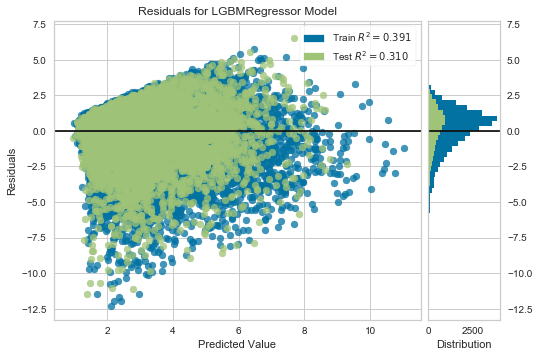

In [120]:
visualizer = ResidualsPlot(Final_LGBM)
visualizer.fit(X_train_2, y_train_2)
visualizer.score(X_test, (y_test))
A = visualizer.show()

In [121]:
y_test_hat = Final_LGBM.predict(X_test)
y_train_hat = Final_LGBM.predict(X_train_2)
test_MAE = mean_absolute_error(y_test, y_test_hat)
train_MAE = mean_absolute_error(y_train_2, y_train_hat)

print('The Training MAE was ' + str(train_MAE))
print('The Test MAE was ' + str(test_MAE))

The Training MAE was 1.2984514703407644
The Test MAE was 1.3656936304225855


The mean absolute error of our test set 5% worse than that of out training set, but that is not terrible. It suggests that our model is slightly overfit to our training data, but for that sake of this project, I will not go any further in trying to lower the MAE of our test set.

In other ML modeling examples, however, I would take this feedback as an indicator that I have room to improve and would re-iterate on the model (feature engineering, hyperparameter tuning, feature selection) in order to create a more generalizable model. 

In [122]:
X.head()

,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,QBP,Receiver_Dist_From_Sideline,...,Down_Distance_3&Medium,Down_Distance_3&Short,Down_Distance_4&Long,Down_Distance_4&Longest,Down_Distance_4&Medium,Down_Distance_4&Short,NDP_CB,NDP_DL,NDP_LB,NDP_STY
18751,4,3,1,6.360000,3.130700,2.538713,0.559044,1.457348,0,14.840000,...,0,1,0,0,0,0,0,1,0,0
32194,2,3,1,6.130000,3.127637,2.898073,0.587787,1.545626,0,10.150000,...,0,1,0,0,0,0,1,0,0,0
17051,1,3,1,4.220000,2.995732,2.567196,0.427879,1.340812,0,17.083330,...,0,1,0,0,0,0,1,0,0,0
1807,1,3,1,10.194635,3.183041,2.933850,0.619501,1.625343,0,10.443331,...,0,1,0,0,0,0,0,0,0,1
46639,4,3,1,2.000000,4.017464,3.891909,1.333421,1.444891,0,6.330000,...,0,1,0,0,0,0,1,0,0,0


In [123]:
X[float_cols] = Scaler.fit_transform(X[float_cols])

In [161]:
Final = Merged_Enc.copy()
index = Final.index
Final = df.loc[index]
Final['Pred_Sep'] = Final_LGBM.predict(X)

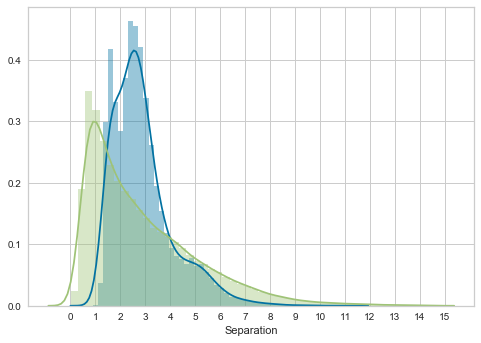

In [162]:
sns.distplot(Final['Pred_Sep'], kde_kws={'bw': .3})
sns.distplot(Final['Separation'], kde_kws={'bw': .3})
A =plt.xticks(range(-0, 16, 1))
# Add legend 

In [163]:
Final['Pred_Sep'].describe()

count    43699.000000
mean         2.887376
std          1.221673
min          0.903254
25%          2.025167
50%          2.635504
75%          3.355408
max         11.031731
Name: Pred_Sep, dtype: float64

In [164]:
Final['Separation'].describe()

count    43699.000000
mean         2.890224
std          2.205928
min          0.020000
25%          1.159698
50%          2.276225
75%          4.061040
max         14.472159
Name: Separation, dtype: float64

# Results!

In [128]:
import shap

In [129]:
%time 
shap_values = shap.TreeExplainer(Final_LGBM).shap_values(X)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.06 µs


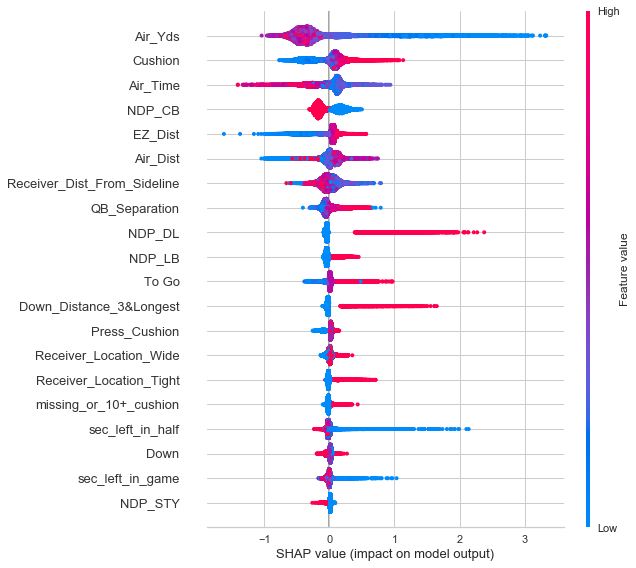

In [130]:
shap.summary_plot(shap_values, X)

The above [SHAP plot](https://github.com/slundberg/shap) gives an overview of how each feature contributed to the predicting separation on the whole. The Features (y-axis) are ordered by how often they were of significance to the prediction, with the most influential featreu (Air Yards) at the top. The points themselves show how the value of each feauture was used to create the predictions. For example, when Air Yards values are low (blue) we can see that the model predicts a higher Separation (which, thankfully, makes sense). 

If we look at another feature, like NDP_DL (which is either a 1 or 0 value), it indicates that the model correctly understands that if the nearest defender was a DL on the play, it usually signified that the separation would higher, and therefore contributed to prediciting a higher separation value as well. 

## Examples 

In [168]:
explainer = shap.TreeExplainer(Final_LGBM)
Display = X.copy()
Display[float_cols] = Scaler.inverse_transform(Display[float_cols])
Display[skewed_feats] = np.expm1(Display[skewed_feats])
Display['Air_Yds'] = Display['Air_Yds'] - 20
Display[float_cols] = Display[float_cols].round(2)

In [169]:
Display.head()

,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,QBP,Receiver_Dist_From_Sideline,...,Down_Distance_3&Medium,Down_Distance_3&Short,Down_Distance_4&Long,Down_Distance_4&Longest,Down_Distance_4&Medium,Down_Distance_4&Short,NDP_CB,NDP_DL,NDP_LB,NDP_STY
18751,4,3,1,6.36,1.89,11.66,0.75,3.29,0,14.84,...,0,1,0,0,0,0,0,1,0,0
32194,2,3,1,6.13,1.82,17.14,0.80,3.69,0,10.15,...,0,1,0,0,0,0,1,0,0,0
17051,1,3,1,4.22,-1.00,12.03,0.53,2.82,0,17.08,...,0,1,0,0,0,0,1,0,0,0
1807,1,3,1,10.19,3.12,17.80,0.86,4.08,0,10.44,...,0,1,0,0,0,0,0,0,0,1
46639,4,3,1,2.00,34.56,48.00,2.79,3.24,0,6.33,...,0,1,0,0,0,0,1,0,0,0


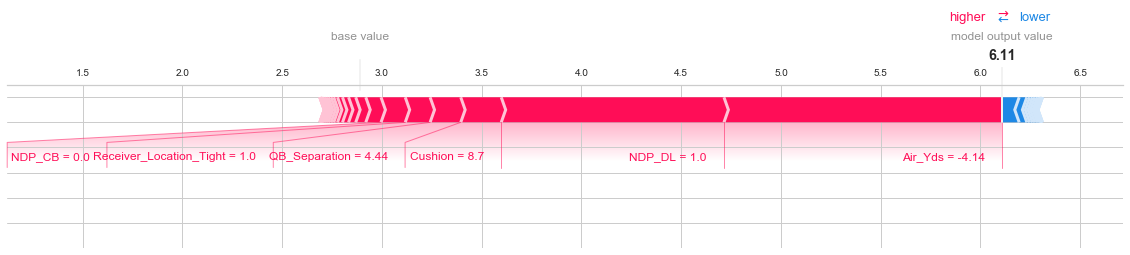

In [170]:
play = 92
shap.force_plot(explainer.expected_value, shap_values[play,:], Display.iloc[play,:], matplotlib = True)

In [171]:
#Actual Separation - Not Bad!
Final.iloc[92,:]['Separation']

8.276194572

On the above play, the model predicted that the player would have a **separation of 6.11 yards**. Due to the fact that the pass was just 2.82 yards downfield, the nearest defender was a DL (NDP_DL = 1), and he had 8.7 yards of cushion on the play, the model predicted that he would have a separation far above average (which is 2.8 yards, as indicated by the words *base value* along the axis. 

On the play, the player had an **actual separation of 8.3 yards**. Not bad!

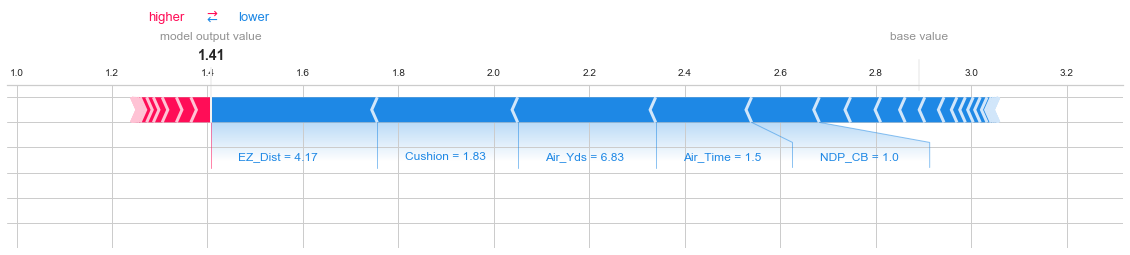

In [172]:
shap.force_plot(explainer.expected_value, shap_values[84,:], Display.iloc[84,:], matplotlib = True)

In [136]:
#Actual Separation - Also looks good!
Final.iloc[84,:]['Separation']

1.52764523

On this play, the model predicted that the player would have a **separation of 1.41 yards**. This was due to the fact that the receiver was 4.2 yards from the back of the endzone, had just 1.8 yards of separation at snap, and was gaurded by a CB at the time the pass arrived. 

On the play, the player had an **actual separation of 1.5 yards**. Again, a very reasonable error.

# More Results!

In [137]:
Final = Final[['Season', 'Receiver', 'Nearest_Defender', 'Separation', 'Pred_Sep', 'TD', 'Pass Yds', 'INT', 'Cmp', 'Team']]
Final['Sep_Diff'] = Final['Separation'] - Final['Pred_Sep']

In [138]:
COUNT_df = Final.groupby(['Receiver', 'Season']).nunique()
COUNT_df = COUNT_df.rename(columns = {'Separation':'Targets'})
COUNT_df = COUNT_df[['Targets']]
Final_df = Final.merge(COUNT_df, on = ['Receiver', 'Season'])

### Year over Year stability of Separation Differential

Below is a table showing how correlated a receivers average Separation Differential is year-over-year. Turns out, among receivers with at least 70 receptions in each of the last 3 years, there is a low, but non-zero correlation between those figures over three seasons. 

In [156]:
YoY = Final_df[Final_df['Targets'] >= 70]
YoY = YoY.groupby(['Receiver', 'Season'])[['Separation', 'Pred_Sep', 'Sep_Diff']].mean()
YoY = pd.pivot_table(YoY, values='Sep_Diff',index='Receiver', columns=['Season']).corr().round(3)
YoY

Season,2017,2018,2019
Season,,,
2017,1.000,0.365,0.281
2018,0.365,1.000,0.425
2019,0.281,0.425,1.000


### How do the players stack up?

In [140]:
Season = Final_df[['Receiver', 'Separation', 'Pred_Sep', 'Sep_Diff', 'Season', 'Targets']]
Season = Season.groupby(['Receiver', 'Season']).mean().reset_index().round(2)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
0,A.J. Brown,2019,2.26,2.34,-0.07,94
1,A.J. Derby,2017,3.07,2.97,0.10,39
2,A.J. Derby,2018,1.57,3.18,-1.61,5
3,A.J. Green,2017,2.34,2.30,0.04,141
4,A.J. Green,2018,2.03,2.29,-0.26,77


In [141]:
#Create df since 2017

Since17 = Final[['Receiver', 'Separation', 'Pred_Sep', 'Sep_Diff']]
Since17_df = Since17.groupby(['Receiver']).mean().reset_index().round(2)
COUNT = Final.groupby(['Receiver']).nunique()
COUNT = COUNT.rename(columns = {'Separation':'Targets'})
COUNT_1 = COUNT[['Targets']]
Since17_df = Since17_df.merge(COUNT_1, on = ['Receiver'])

## Top 10 Highest Average Separation Above Expectation

In [142]:
Career = Since17_df[Since17_df['Targets'] > 150].sort_values(['Sep_Diff'], ascending = False)
Career.head(10)

,Receiver,Separation,Pred_Sep,Sep_Diff,Targets
117,Chris Hogan,3.09,2.68,0.41,154
584,Sammy Watkins,2.96,2.56,0.40,253
10,Albert Wilson,3.73,3.36,0.37,159
679,Will Fuller,2.95,2.61,0.34,174
666,Tyreek Hill,3.26,2.95,0.31,374
94,Calvin Ridley,3.02,2.72,0.30,184
623,Ted Ginn,3.02,2.75,0.27,188
180,Davante Adams,3.03,2.77,0.26,434
195,DeSean Jackson,2.77,2.52,0.25,172
25,Amari Cooper,2.76,2.53,0.23,337


## Top 10 Lowest Average Separation Above Expectation

In [143]:
Career.sort_values(['Sep_Diff'], ascending = True).head(10)

,Receiver,Separation,Pred_Sep,Sep_Diff,Targets
264,Golden Tate,2.66,3.10,-0.43,324
429,Larry Fitzgerald,2.59,3.00,-0.41,379
561,Rob Gronkowski,2.39,2.77,-0.38,209
187,David Njoku,2.74,3.09,-0.35,157
98,Cameron Brate,2.61,2.96,-0.35,176
21,Allen Robinson,2.14,2.46,-0.32,261
199,Delanie Walker,2.83,3.12,-0.30,162
413,Kenny Golladay,2.12,2.35,-0.23,275
349,Jimmy Graham,2.99,3.21,-0.22,250
320,Jared Cook,2.75,2.94,-0.19,254


## 2019 Only

In [144]:
df_2019 = Season[(Season['Targets'] > 75) & (Season['Season'] == 2019)].sort_values(['Sep_Diff'], ascending = False).reset_index(drop = True)
df_2019.head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
0,Diontae Johnson,2019,3.62,3.13,0.49,92
1,Davante Adams,2019,3.31,2.85,0.45,149
2,Tyreek Hill,2019,3.23,2.91,0.32,114
3,Sterling Shepard,2019,3.13,2.81,0.32,83
4,Sammy Watkins,2019,3.03,2.72,0.32,108
5,Christian Kirk,2019,3.46,3.15,0.31,108
6,Cole Beasley,2019,3.25,2.94,0.30,111
7,Travis Kelce,2019,3.05,2.76,0.28,158
8,Tyler Higbee,2019,3.70,3.42,0.28,88
9,Cooper Kupp,2019,3.39,3.12,0.26,134


In [145]:
df_2019.sort_values(['Sep_Diff'], ascending = True).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
66,Golden Tate,2019,2.17,2.69,-0.52,85
65,Marvin Jones,2019,2.09,2.51,-0.43,91
64,Larry Fitzgerald,2019,2.98,3.33,-0.35,109
63,Julio Jones,2019,2.16,2.49,-0.32,156
62,Mike Gesicki,2019,2.62,2.93,-0.31,89
61,Kenny Golladay,2019,1.95,2.23,-0.28,113
60,Allen Robinson,2019,2.25,2.49,-0.24,153
59,Zach Ertz,2019,2.73,2.97,-0.23,138
58,Dallas Goedert,2019,3.10,3.32,-0.23,92
57,DeVante Parker,2019,2.03,2.23,-0.20,126


In [146]:
df_2019.sort_values(['Separation'], ascending = True).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
61,Kenny Golladay,2019,1.95,2.23,-0.28,113
43,Mike Williams,2019,2.00,2.09,-0.09,90
57,DeVante Parker,2019,2.03,2.23,-0.20,126
65,Marvin Jones,2019,2.09,2.51,-0.43,91
49,Terry McLaurin,2019,2.11,2.24,-0.13,93
63,Julio Jones,2019,2.16,2.49,-0.32,156
40,Darius Slayton,2019,2.16,2.20,-0.04,84
44,Robby Anderson,2019,2.17,2.27,-0.10,96
66,Golden Tate,2019,2.17,2.69,-0.52,85
48,Michael Gallup,2019,2.22,2.34,-0.12,113


In [147]:
df_2019.sort_values(['Pred_Sep'], ascending = False).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
54,George Kittle,2019,3.29,3.46,-0.17,115
8,Tyler Higbee,2019,3.70,3.42,0.28,88
64,Larry Fitzgerald,2019,2.98,3.33,-0.35,109
58,Dallas Goedert,2019,3.10,3.32,-0.23,92
34,Robert Woods,2019,3.33,3.32,0.00,138
52,Darren Waller,2019,3.14,3.31,-0.17,117
56,Jamison Crowder,2019,3.01,3.20,-0.20,121
35,Dede Westbrook,2019,3.20,3.19,0.00,101
5,Christian Kirk,2019,3.46,3.15,0.31,108
11,Austin Hooper,2019,3.39,3.15,0.24,96


# Exceptional Separation Rate

For me, these numbers are a little underwhelming. No one is going to jump out of their seat to hear 'Davante Adams exceeds his predicted separation by .4 yards per target!' Well, I will, but let's see if we can't create something more digestable. Below I will create a stat called 'Exceptional Separation Rate' that tallies all the instances where a receiver exceeds their predicted separation by 2 yards, and divide that by their total targets to see how often they are beating the odds. 

In [148]:
Final_ES = Final.copy()
Final_ES['ES'] = 0
Final_ES['ES'].loc[Final_ES['Sep_Diff']> 0] = 1
Final_ES = Final_ES.merge(COUNT_1, on = ['Receiver'])
Final_ES = Final_ES[['Receiver', 'ES', 'Targets', 'Sep_Diff']]
Final_ES = Final_ES.groupby(['Receiver']).mean().round(2)
Final_ES = Final_ES.sort_values(['ES'], ascending = False)
Final_ES = Final_ES[Final_ES['Targets'] >= 150]
Final_ES.head(10)

,ES,Targets,Sep_Diff
Receiver,,,
Albert Wilson,0.55,159.0,0.37
Davante Adams,0.51,434.0,0.26
Cooper Kupp,0.51,296.0,0.21
Calvin Ridley,0.51,184.0,0.30
Tyreek Hill,0.49,374.0,0.31
Chris Hogan,0.49,154.0,0.41
Ted Ginn,0.49,188.0,0.27
Christian Kirk,0.49,176.0,0.09
Sammy Watkins,0.49,253.0,0.40


In [149]:
Final_ES.sort_values(['ES'], ascending = True).head(10)

,ES,Targets,Sep_Diff
Receiver,,,
Larry Fitzgerald,0.30,379.0,-0.41
Kenny Golladay,0.30,275.0,-0.23
Delanie Walker,0.31,162.0,-0.30
Devin Funchess,0.31,202.0,-0.09
Golden Tate,0.32,324.0,-0.43
Allen Robinson,0.33,261.0,-0.32
Rob Gronkowski,0.33,209.0,-0.38
DeVante Parker,0.33,267.0,-0.18
Cameron Brate,0.34,176.0,-0.35


## Why should you care?

I don't want your takeaway here to see the above list and think 'Julio Jones is Bad' or 'Sammy Watkins is amazing.' The goal of this exercise is try and extract information from recevier separation, and the analysis doesn't end with these numbers. In an attmept to see how this stat looks on the team scale, I correlated *win percentage* over the last three seasons with the teams *average team separation differential* to see how this stat did to predict team success. 

In [150]:
WinPct = [.813, .750, .438, .563, .625, .438, .625, .375, .313, .875, .438, .750, 
          .688, .344, .500, .375, .500, .625, .438, .563, .438, .563, .500, .313, 
          .813, .438, .188, .125, .813, .250, .313, .219]

WP_AS = [.704, .551, .510, .490, .746, .451, .500, .560, .375, .673, .625, .354, 
         .660, .608, .440, .648, .277, .736, .540, .375, .566, .354, .647, .469, 
         .333, .500, .312, .354, .250, .510, .340, .383]

Teams = ['KC','GB','HOU','SF','NE','JAX','ATL','DAL','DEN','LA','PIT','TB','BAL',
         'SEA','IND','PHI','CLE','NO','LAC','MIA','TEN','OAK','MIN','CAR','NYJ',
         'BUF','CIN','WAS','NYG','CHI','ARI','DET']


d = {'Team': Teams, 'Win Pct': WP_AS}
Three_Year = pd.DataFrame(d)

In [151]:
Teams = Final[['Separation', 'Pred_Sep','Team']]
Teams['Sep_Diff'] = Teams['Separation'] - Teams['Pred_Sep']
Team_df = Teams.groupby(['Team']).mean().sort_values(['Sep_Diff'], ascending = False)
Combined = Team_df.merge(Three_Year, on = 'Team')
Combined.round(2).head(32)

,Team,Separation,Pred_Sep,Sep_Diff,Win Pct
0,KC,3.28,2.98,0.30,0.70
1,GB,3.20,3.06,0.14,0.55
2,LA,3.14,3.06,0.09,0.67
3,HOU,2.90,2.82,0.08,0.51
4,IND,3.01,2.94,0.06,0.44
5,SEA,2.93,2.86,0.06,0.61
6,JAX,2.97,2.91,0.06,0.45
7,NE,2.88,2.82,0.06,0.75
8,ATL,2.95,2.89,0.06,0.50
9,SF,2.99,2.93,0.06,0.49


Amazingly enough, teams with higher average separation differentials **won more often** than teams with lower separation differentials.

In [157]:
print('Correlation value of Team Winning Pct and Separation Differential: ' + str(Combined['Win Pct'].corr(Combined['Sep_Diff'], method = 'spearman').round(3)))

Correlation value of Team Winning Pct and Separation Differential: 0.645


I know what you are thinking, 'of course it is! Separation is a good thing, so teams with higher separation win more!' 

Yes, that is true, BUT, separation differential is actually a **better predictor of winning** than average separation. 

In [158]:
print('Correlation value of Team Winning Pct and Average Separtion: ' + str(Combined['Win Pct'].corr(Combined['Separation'], method = 'spearman').round(3)))


Correlation value of Team Winning Pct and Average Separtion: 0.486


# Thanks for reading!

Thank you all for reading. If you have any questions, suggestions, or any feedback at all, feel free to reach out at JesseDCohen@gmail.com. 

Calvin Ridley is the *REAL DEAL*